# Handeling Data

## Load data and quick overview

In [1]:
# import numpy as np
# print(np.__version__)

In [2]:
# !pip install scikit-surprise

In [3]:
# # Downgrade NumPy and reinstall surprise to link against it
# !pip install "numpy<2.0"
# !pip install scikit-surprise

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'the-movies-dataset' dataset.
Path to dataset files: /kaggle/input/the-movies-dataset


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
warnings.filterwarnings('ignore')

In [6]:
main_path = "/kaggle/input/the-movies-dataset/"
movies_metadata_path = main_path + "movies_metadata.csv"
credits_path = main_path + "credits.csv"
keywords_path = main_path + "keywords.csv"
links_path = main_path + "links_small.csv"
ratings_path = main_path + "ratings_small.csv"

In [7]:
df = pd.read_csv(movies_metadata_path)
df.head().transpose()

0  \
adult                                                              False   
belongs_to_collection  {'id': 10194, 'name': 'Toy Story Collection', ...   
budget                                                          30000000   
genres                 [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
homepage                            http://toystory.disney.com/toy-story   
id                                                                   862   
imdb_id                                                        tt0114709   
original_language                                                     en   
original_title                                                 Toy Story   
overview               Led by Woody, Andy's toys live happily in his ...   
popularity                                                     21.946943   
poster_path                             /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
production_companies      [{'name': 'Pixar Animation Studios', 'id': 3}]   
production_countries   [{'iso_3166_1': 'US', 'name': 'United States o...   
release_date                                                  1995-10-30   
revenue                                                      373554033.0   
runtime                                                             81.0   
spoken_languages                [{'iso_639_1': 'en', 'name': 'English'}]   
status                                                          Released   
tagline                                                              NaN   
title                                                          Toy Story   
video                                                              False   
vote_average                                                         7.7   
vote_count                                                        5415.0   

                                                                       1  \
adult                                                              False   
belongs_to_collection                                                NaN   
budget                                                          65000000   
genres                 [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
homepage                                                             NaN   
id                                                                  8844   
imdb_id                                                        tt0113497   
original_language                                                     en   
original_title                                                   Jumanji   
overview               When siblings Judy and Peter discover an encha...   
popularity                                                     17.015539   
poster_path                             /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
production_companies   [{'name': 'TriStar Pictures', 'id': 559}, {'na...   
production_countries   [{'iso_3166_1': 'US', 'name': 'United States o...   
release_date                                                  1995-12-15   
revenue                                                      262797249.0   
runtime                                                            104.0   
spoken_languages       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
status                                                          Released   
tagline                        Roll the dice and unleash the excitement!   
title                                                            Jumanji   
video                                                              False   
vote_average                                                         6.9   
vote_count                                                        2413.0   

                                                                       2  \
adult                                                              False   
belongs_to_collection  {'id': 119050, 'name': 'Grumpy Old Men Collect...   
budget                                   

In [8]:
print("Missing values in Train DataFrame:")
missing_df = df.isnull().sum().sort_values(ascending=False)
missing_df_percent = (missing_df / len(df)) * 100
missing_df_info = pd.DataFrame({'Missing Count': missing_df, 'Missing Percentage (%)': missing_df_percent})
display(missing_df_info[missing_df_info['Missing Count'] > 0])

Missing values in Train DataFrame:


Missing Count  Missing Percentage (%)
belongs_to_collection          40972               90.115691
homepage                       37684               82.883913
tagline                        25054               55.104914
overview                         954                2.098271
poster_path                      386                0.848986
runtime                          263                0.578454
status                            87                0.191352
release_date                      87                0.191352
imdb_id                           17                0.037391
original_language                 11                0.024194
vote_average                       6                0.013197
vote_count                         6                0.013197
title                              6                0.013197
video                              6                0.013197
spoken_languages                   6                0.013197
revenue                            6                0.013197
popularity                         5                0.010997
production_countries               3                0.006598
production_companies               3                0.006598

## Missing values

In [9]:
# Analyze missing value percentages from missing_df_info
high_missing_cols = missing_df_info[missing_df_info['Missing Percentage (%)'] > 50].index.tolist()
moderate_missing_cols = missing_df_info[(missing_df_info['Missing Percentage (%)'] <= 50) & (missing_df_info['Missing Percentage (%)'] > 1)].index.tolist()
low_missing_cols = missing_df_info[missing_df_info['Missing Percentage (%)'] <= 1].index.tolist()

print("Columns with high missing percentage (>50%):", high_missing_cols)
print("Columns with moderate missing percentage (1%-50%):", moderate_missing_cols)
print("Columns with low missing percentage (<=1%):", low_missing_cols)

# Determine handling strategy for each column with missing values
handling_strategy = {}

# High missing percentage: Consider dropping
for col in high_missing_cols:
    handling_strategy[col] = "Drop column due to high missing percentage"

# Moderate missing percentage: Consider imputation based on data type
# 'overview' is text, imputation might not be meaningful, could consider dropping or using a placeholder
if 'overview' in moderate_missing_cols:
    handling_strategy['overview'] = "Consider dropping or using a placeholder for text data"

# Low missing percentage: Consider imputation or dropping rows
# For numerical columns like 'runtime', 'vote_average', 'vote_count', 'revenue', 'popularity', consider mean/median imputation
numerical_low_missing = ['runtime', 'vote_average', 'vote_count', 'revenue', 'popularity']
for col in low_missing_cols:
    if col in numerical_low_missing:
        handling_strategy[col] = "Impute with mean or median"
    elif col in ['status', 'release_date', 'imdb_id', 'original_language', 'title', 'video', 'spoken_languages', 'production_countries', 'production_companies', 'poster_path']:
         handling_strategy[col] = "Consider imputation (e.g., mode, placeholder) or dropping rows"


# Special handling for 'adult' column based on previous observation
handling_strategy['adult'] = "Investigate and potentially remove incorrect entries (e.g., 'R')"


print("\nIdentified Handling Strategy for each column with missing values:")
for col, strategy in handling_strategy.items():
    print(f"- {col}: {strategy}")

Columns with high missing percentage (>50%): ['belongs_to_collection', 'homepage', 'tagline']
Columns with moderate missing percentage (1%-50%): ['overview']
Columns with low missing percentage (<=1%): ['poster_path', 'runtime', 'status', 'release_date', 'imdb_id', 'original_language', 'vote_average', 'vote_count', 'title', 'video', 'spoken_languages', 'revenue', 'popularity', 'production_countries', 'production_companies', 'genres', 'id', 'adult', 'budget', 'original_title']

Identified Handling Strategy for each column with missing values:
- belongs_to_collection: Drop column due to high missing percentage
- homepage: Drop column due to high missing percentage
- tagline: Drop column due to high missing percentage
- overview: Consider dropping or using a placeholder for text data
- poster_path: Consider imputation (e.g., mode, placeholder) or dropping rows
- runtime: Impute with mean or median
- status: Consider imputation (e.g., mode, placeholder) or dropping rows
- release_date: Con

In [10]:
# 1. Drop columns with high missing percentages
cols_to_drop = ['belongs_to_collection', 'homepage', 'tagline']
df = df.drop(columns=cols_to_drop)

# 2. Fill missing values in 'overview' with a placeholder
df['overview'] = df['overview'].fillna('No overview available')

# Inspect the 'popularity' column to identify the non-numeric values
print(df['popularity'].dtype)
print(df['popularity'].unique())

# Attempt to convert 'popularity' to numeric, coercing errors
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

# Now retry the imputation for numerical columns
numerical_cols_to_impute = ['runtime', 'vote_average', 'vote_count', 'revenue', 'popularity']
for col in numerical_cols_to_impute:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# Fill missing values in remaining columns with low missing percentages with a placeholder
remaining_missing_cols = df.columns[df.isnull().any()].tolist()
cols_to_fill_unknown = [col for col in remaining_missing_cols if col not in numerical_cols_to_impute and col != 'adult']

for col in cols_to_fill_unknown:
    df[col] = df[col].fillna('Unknown')

# Investigate and remove incorrect entries in 'adult' column
df = df[df['adult'].isin(['True', 'False'])]

# Verify that missing values have been handled
print("Missing values after handling:")
display(df.isnull().sum().sort_values(ascending=False))

object
[21.946943 17.015539 11.7129 ... '0.903007' '0.003503' '0.163015']
Missing values after handling:


adult                   0
budget                  0
genres                  0
id                      0
imdb_id                 0
original_language       0
original_title          0
overview                0
popularity              0
poster_path             0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
video                   0
vote_average            0
vote_count              0
dtype: int64

In [11]:
df.shape

(45463, 21)

In [12]:
credits_df = pd.read_csv(credits_path)
keywords_df = pd.read_csv(keywords_path)
links_df = pd.read_csv(links_path)
ratings_df = pd.read_csv(ratings_path)

In [13]:
credits_df.columns

Index(['cast', 'crew', 'id'], dtype='object')

In [14]:
credits_df.head()

cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)',...   
1  [{'cast_id': 1, 'character': 'Alan Parrish', '...   
2  [{'cast_id': 2, 'character': 'Max Goldman', 'c...   
3  [{'cast_id': 1, 'character': "Savannah 'Vannah...   
4  [{'cast_id': 1, 'character': 'George Banks', '...   

                                                crew     id  
0  [{'credit_id': '52fe4284c3a36847f8024f49', 'de...    862  
1  [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...   8844  
2  [{'credit_id': '52fe466a9251416c75077a89', 'de...  15602  
3  [{'credit_id': '52fe44779251416c91011acb', 'de...  31357  
4  [{'credit_id': '52fe44959251416c75039ed7', 'de...  11862

In [15]:
credits_df.isnull().sum()

cast    0
crew    0
id      0
dtype: int64

In [16]:
keywords_df.columns

Index(['id', 'keywords'], dtype='object')

In [17]:
keywords_df.head()

id                                           keywords
0    862  [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1   8844  [{'id': 10090, 'name': 'board game'}, {'id': 1...
2  15602  [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
3  31357  [{'id': 818, 'name': 'based on novel'}, {'id':...
4  11862  [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...

In [18]:
keywords_df.isnull().sum()

id          0
keywords    0
dtype: int64

In [19]:
links_df.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [20]:
links_df.head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

In [21]:
links_df.isnull().sum()

movieId     0
imdbId      0
tmdbId     13
dtype: int64

In [22]:
links_df = links_df.dropna(subset=['tmdbId'])
print("Missing values in links_df after handling:")
display(links_df.isnull().sum())

Missing values in links_df after handling:


movieId    0
imdbId     0
tmdbId     0
dtype: int64

In [23]:
ratings_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [24]:
ratings_df.head()

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [25]:
print("Columns of df:", df.columns)
print("Columns of credits_df:", credits_df.columns)
print("Columns of keywords_df:", keywords_df.columns)
print("Columns of links_df:", links_df.columns)
print("Columns of ratings_df:", ratings_df.columns)

Columns of df: Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
Columns of credits_df: Index(['cast', 'crew', 'id'], dtype='object')
Columns of keywords_df: Index(['id', 'keywords'], dtype='object')
Columns of links_df: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
Columns of ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [26]:
print("Missing values in 'id' column of df:", df['id'].isnull().sum())
print("Missing values in 'id' column of credits_df:", credits_df['id'].isnull().sum())
print("Missing values in 'id' column of keywords_df:", keywords_df['id'].isnull().sum())
print("Missing values in 'tmdbId' column of links_df:", links_df['tmdbId'].isnull().sum())
print("Missing values in 'movieId' column of links_df:", links_df['movieId'].isnull().sum())
print("Missing values in 'movieId' column of ratings_df:", ratings_df['movieId'].isnull().sum())

Missing values in 'id' column of df: 0
Missing values in 'id' column of credits_df: 0
Missing values in 'id' column of keywords_df: 0
Missing values in 'tmdbId' column of links_df: 0
Missing values in 'movieId' column of links_df: 0
Missing values in 'movieId' column of ratings_df: 0


In [27]:
print("Data type of 'id' in df:", df['id'].dtype)
print("Data type of 'id' in credits_df:", credits_df['id'].dtype)
print("Data type of 'id' in keywords_df:", keywords_df['id'].dtype)
print("Data type of 'tmdbId' in links_df:", links_df['tmdbId'].dtype)
print("Data type of 'movieId' in links_df:", links_df['movieId'].dtype)
print("Data type of 'movieId' in ratings_df:", ratings_df['movieId'].dtype)

Data type of 'id' in df: object
Data type of 'id' in credits_df: int64
Data type of 'id' in keywords_df: int64
Data type of 'tmdbId' in links_df: float64
Data type of 'movieId' in links_df: int64
Data type of 'movieId' in ratings_df: int64


In [28]:
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df.dropna(subset=['id'], inplace=True)
df['id'] = df['id'].astype(int)

links_df.dropna(subset=['tmdbId'], inplace=True)
links_df['tmdbId'] = links_df['tmdbId'].astype(int)

print("Updated data type of 'id' in df:", df['id'].dtype)
print("Updated data type of 'tmdbId' in links_df:", links_df['tmdbId'].dtype)

Updated data type of 'id' in df: int64
Updated data type of 'tmdbId' in links_df: int64


## Handling jsons

In [29]:
import json

def is_json_like(value):
    """Checks if a string value is likely a JSON array or object."""
    if isinstance(value, str):
        value = value.strip()
        if (value.startswith('[') and value.endswith(']')) or \
           (value.startswith('{') and value.endswith('}')):
            try:
                json.loads(value)
                return True
            except json.JSONDecodeError:
                pass
    return False

# Identify columns that might contain JSON
json_columns = []
for col in df.columns:
    # Check a sample of non-null values to see if they are json-like
    sample_values = df[col].dropna().sample(min(100, len(df[col].dropna())))
    if any(sample_values.apply(is_json_like)):
        json_columns.append(col)

print("Columns that appear to contain JSON format:", json_columns)

Columns that appear to contain JSON format: ['genres', 'production_companies', 'production_countries', 'spoken_languages']


In [30]:
copy_df = df.copy()

In [31]:
import ast
import numpy as np

def extract_names_and_handle_empty(json_list_string):
    """Extracts names from a string representation of a list of dictionaries and handles empty lists as NaN."""
    if isinstance(json_list_string, str) and json_list_string.startswith('[') and json_list_string.endswith(']'):
        try:
            # Use ast.literal_eval to safely evaluate the string as a Python literal
            data_list = ast.literal_eval(json_list_string)
            if isinstance(data_list, list):
                if not data_list:  # Check if the list is empty
                    return np.nan  # Replace empty list with NaN
                names = [item.get('name', '') for item in data_list if isinstance(item, dict) and 'name' in item]
                return ', '.join(names)
        except (ValueError, SyntaxError):
            pass
    return '' # Return empty string for non-list strings or evaluation errors

# Columns identified as containing JSON format
json_columns = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

# Apply the extraction function and handle empty lists to copy_df
for col in json_columns:
    if col in copy_df.columns:
        copy_df[col] = copy_df[col].apply(extract_names_and_handle_empty)
        # Now fill the NaN values (which were empty lists) with 'Unknown'
        copy_df[col] = copy_df[col].fillna('Unknown')

# Display the head of the modified copy_df DataFrame to confirm
display(copy_df.head().transpose())

0  \
adult                                                             False   
budget                                                         30000000   
genres                                        Animation, Comedy, Family   
id                                                                  862   
imdb_id                                                       tt0114709   
original_language                                                    en   
original_title                                                Toy Story   
overview              Led by Woody, Andy's toys live happily in his ...   
popularity                                                    21.946943   
poster_path                            /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
production_companies                            Pixar Animation Studios   
production_countries                           United States of America   
release_date                                                 1995-10-30   
revenue                                                     373554033.0   
runtime                                                            81.0   
spoken_languages                                                English   
status                                                         Released   
title                                                         Toy Story   
video                                                             False   
vote_average                                                        7.7   
vote_count                                                       5415.0   

                                                                      1  \
adult                                                             False   
budget                                                         65000000   
genres                                       Adventure, Fantasy, Family   
id                                                                 8844   
imdb_id                                                       tt0113497   
original_language                                                    en   
original_title                                                  Jumanji   
overview              When siblings Judy and Peter discover an encha...   
popularity                                                    17.015539   
poster_path                            /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg   
production_companies  TriStar Pictures, Teitler Film, Interscope Com...   
production_countries                           United States of America   
release_date                                                 1995-12-15   
revenue                                                     262797249.0   
runtime                                                           104.0   
spoken_languages                                      English, Français   
status                                                         Released   
title                                                           Jumanji   
video                                                             False   
vote_average                                                        6.9   
vote_count                                                       2413.0   

                                                                      2  \
adult                                                             False   
budget                                                                0   
genres                                                  Romance, Comedy   
id                                                                15602   
imdb_id                                                       tt0113228   
original_language                                                    en   
original_title                                         Grumpier Old Men   
overview              A family wedding reignites the ancient feud be...   
popularity                                                      11.7129   
poster_path       

In [32]:
parsed_json_columns = ['genres', 'production_companies', 'production_countries', 'spoken_languages']

print("Count and percentage of 'Unknown' values in parsed JSON columns:")
for col in parsed_json_columns:
    if col in copy_df.columns:
        unknown_count = (copy_df[col] == 'Unknown').sum()
        total_count = len(copy_df[col])
        unknown_percentage = (unknown_count / total_count) * 100 if total_count > 0 else 0
        print(f"- {col}: {unknown_count} ('Unknown' values) out of {total_count} (Total values) - {unknown_percentage:.2f}%")

Count and percentage of 'Unknown' values in parsed JSON columns:
- genres: 2442 ('Unknown' values) out of 45463 (Total values) - 5.37%
- production_companies: 11875 ('Unknown' values) out of 45463 (Total values) - 26.12%
- production_countries: 6282 ('Unknown' values) out of 45463 (Total values) - 13.82%
- spoken_languages: 3829 ('Unknown' values) out of 45463 (Total values) - 8.42%


In [33]:
df = copy_df.copy()

In [34]:
import json

def is_json_like(value):
    """Checks if a string value is likely a JSON array or object."""
    if isinstance(value, str):
        value = value.strip()
        if (value.startswith('[') and value.endswith(']')) or \
           (value.startswith('{') and value.endswith('}')):
            try:
                json.loads(value)
                return True
            except json.JSONDecodeError:
                pass
    return False

# Identify columns that might contain JSON in credits_df
json_columns_credits = []
for col in credits_df.columns:
    # Check a sample of non-null values to see if they are json-like
    sample_values = credits_df[col].dropna().sample(min(100, len(credits_df[col].dropna())))
    if any(sample_values.apply(is_json_like)):
        json_columns_credits.append(col)

print("Columns in credits_df that appear to contain JSON format:", json_columns_credits)

# Identify columns that might contain JSON in keywords_df
json_columns_keywords = []
for col in keywords_df.columns:
    # Check a sample of non-null values to see if they are json-like
    sample_values = keywords_df[col].dropna().sample(min(100, len(keywords_df[col].dropna())))
    if any(sample_values.apply(is_json_like)):
        json_columns_keywords.append(col)

print("Columns in keywords_df that appear to contain JSON format:", json_columns_keywords)

Columns in credits_df that appear to contain JSON format: ['cast', 'crew']
Columns in keywords_df that appear to contain JSON format: ['keywords']


In [35]:
import ast
import numpy as np

def extract_names_from_list(json_list_string, key='name'):
    """Extracts values for a given key from a string representation of a list of dictionaries and handles empty lists as NaN."""
    if isinstance(json_list_string, str) and json_list_string.startswith('[') and json_list_string.endswith(']'):
        try:
            data_list = ast.literal_eval(json_list_string)
            if isinstance(data_list, list):
                if not data_list:  # Check if the list is empty
                    return np.nan  # Replace empty list with NaN
                names = [item.get(key, '') for item in data_list if isinstance(item, dict) and key in item]
                return ', '.join(names)
        except (ValueError, SyntaxError):
            pass
    return '' # Return empty string for non-list strings or evaluation errors

# Handle JSON columns in credits_df
# 'cast' and 'crew' columns contain lists of dictionaries, we'll extract names
credits_df['cast'] = credits_df['cast'].apply(extract_names_from_list, key='name')
credits_df['crew'] = credits_df['crew'].apply(extract_names_from_list, key='name')

# Fill NaN values (originally empty lists) with 'Unknown' in credits_df
credits_df['cast'] = credits_df['cast'].fillna('Unknown')
credits_df['crew'] = credits_df['crew'].fillna('Unknown')

# Handle JSON columns in keywords_df
# 'keywords' column contains a list of dictionaries, we'll extract names
keywords_df['keywords'] = keywords_df['keywords'].apply(extract_names_from_list, key='name')

# Fill NaN values (originally empty lists) with 'Unknown' in keywords_df
keywords_df['keywords'] = keywords_df['keywords'].fillna('Unknown')


print("credits_df after parsing and handling empty lists:")
display(credits_df.head())

print("\nkeywords_df after parsing and handling empty lists:")
display(keywords_df.head())

credits_df after parsing and handling empty lists:


cast  \
0  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...   
1  Robin Williams, Jonathan Hyde, Kirsten Dunst, ...   
2  Walter Matthau, Jack Lemmon, Ann-Margret, Soph...   
3  Whitney Houston, Angela Bassett, Loretta Devin...   
4  Steve Martin, Diane Keaton, Martin Short, Kimb...   

                                                crew     id  
0  John Lasseter, Joss Whedon, Andrew Stanton, Jo...    862  
1  Larry J. Franco, Jonathan Hensleigh, James Hor...   8844  
2  Howard Deutch, Mark Steven Johnson, Mark Steve...  15602  
3  Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...  31357  
4  Alan Silvestri, Elliot Davis, Nancy Meyers, Na...  11862


keywords_df after parsing and handling empty lists:


id                                           keywords
0    862  jealousy, toy, boy, friendship, friends, rival...
1   8844  board game, disappearance, based on children's...
2  15602  fishing, best friend, duringcreditsstinger, ol...
3  31357  based on novel, interracial relationship, sing...
4  11862  baby, midlife crisis, confidence, aging, daugh...

In [36]:
# Columns in credits_df and keywords_df where empty lists were replaced by 'Unknown'
parsed_credits_columns = ['cast', 'crew']
parsed_keywords_columns = ['keywords']

print("Count and percentage of 'Unknown' values in parsed credits_df columns:")
for col in parsed_credits_columns:
    if col in credits_df.columns:
        unknown_count = (credits_df[col] == 'Unknown').sum()
        total_count = len(credits_df[col])
        unknown_percentage = (unknown_count / total_count) * 100 if total_count > 0 else 0
        print(f"- {col}: {unknown_count} ('Unknown' values) out of {total_count} (Total values) - {unknown_percentage:.2f}%")

print("\nCount and percentage of 'Unknown' values in parsed keywords_df columns:")
for col in parsed_keywords_columns:
    if col in keywords_df.columns:
        unknown_count = (keywords_df[col] == 'Unknown').sum()
        total_count = len(keywords_df[col])
        unknown_percentage = (unknown_count / total_count) * 100 if total_count > 0 else 0
        print(f"- {col}: {unknown_count} ('Unknown' values) out of {total_count} (Total values) - {unknown_percentage:.2f}%")

Count and percentage of 'Unknown' values in parsed credits_df columns:
- cast: 2418 ('Unknown' values) out of 45476 (Total values) - 5.32%
- crew: 771 ('Unknown' values) out of 45476 (Total values) - 1.70%

Count and percentage of 'Unknown' values in parsed keywords_df columns:
- keywords: 14795 ('Unknown' values) out of 46419 (Total values) - 31.87%


## Handling duplicates

In [37]:
# Check for duplicates in the key columns
print("Duplicates in 'id' column of df:", df['id'].duplicated().sum())
print("Duplicates in 'id' column of credits_df:", credits_df['id'].duplicated().sum())
print("Duplicates in 'id' column of keywords_df:", keywords_df['id'].duplicated().sum())
print("Duplicates in 'tmdbId' column of links_df:", links_df['tmdbId'].duplicated().sum())
print("Duplicates in 'movieId' column of links_df:", links_df['movieId'].duplicated().sum())
print("Duplicates in 'imbdId' column of links_df:", links_df['imdbId'].duplicated().sum())
print("Duplicates in 'movieId' column of ratings_df:", ratings_df.duplicated(subset=['movieId', 'userId']).sum())

Duplicates in 'id' column of df: 30
Duplicates in 'id' column of credits_df: 44
Duplicates in 'id' column of keywords_df: 987
Duplicates in 'tmdbId' column of links_df: 0
Duplicates in 'movieId' column of links_df: 0
Duplicates in 'imbdId' column of links_df: 0
Duplicates in 'movieId' column of ratings_df: 0


In [38]:
# Remove duplicates from key columns
df.drop_duplicates(subset=['id'], inplace=True)
credits_df.drop_duplicates(subset=['id'], inplace=True)
keywords_df.drop_duplicates(subset=['id'], inplace=True)
links_df.drop_duplicates(subset=['tmdbId'], inplace=True)
ratings_df.drop_duplicates(subset=['movieId', 'userId'], inplace=True)

print("Duplicates in 'id' column of df after removal:", df['id'].duplicated().sum())
print("Duplicates in 'id' column of credits_df after removal:", credits_df['id'].duplicated().sum())
print("Duplicates in 'id' column of keywords_df after removal:", keywords_df['id'].duplicated().sum())
print("Duplicates in 'tmdbId' column of links_df after removal:", links_df['tmdbId'].duplicated().sum()) # Re-checking for completeness
print("Duplicates in 'movieId' column of links_df after removal:", links_df['movieId'].duplicated().sum()) # Re-checking for completeness
print("Duplicates in 'movieId' column of ratings_df after removal:", ratings_df['movieId'].duplicated().sum())

Duplicates in 'id' column of df after removal: 0
Duplicates in 'id' column of credits_df after removal: 0
Duplicates in 'id' column of keywords_df after removal: 0
Duplicates in 'tmdbId' column of links_df after removal: 0
Duplicates in 'movieId' column of links_df after removal: 0
Duplicates in 'movieId' column of ratings_df after removal: 90938


In [39]:
print("Shape of df:", df.shape)
print("Shape of credits_df:", credits_df.shape)
print("Shape of keywords_df:", keywords_df.shape)
print("Shape of links_df:", links_df.shape)
print("Shape of ratings_df:", ratings_df.shape)

Shape of df: (45433, 21)
Shape of credits_df: (45432, 3)
Shape of keywords_df: (45432, 2)
Shape of links_df: (9112, 3)
Shape of ratings_df: (100004, 4)


## Merging dataframes

In [40]:
# Merge df, credits_df, and keywords_df on 'id'
merged_df = pd.merge(df, credits_df, on='id', how='inner')
merged_df = pd.merge(merged_df, keywords_df, on='id', how='inner')

# Merge with links_df using tmdbId from links_df and id from merged_df
# links_df has 'movieId' (MovieLens ID) and 'tmdbId' (TMDB ID)
merged_df = pd.merge(merged_df, links_df, left_on='id', right_on='tmdbId', how='inner')

# Now merge the result with ratings_df using movieId (MovieLens ID)
merged_df = pd.merge(merged_df, ratings_df, on='movieId', how='inner')

print("Shape of the merged dataframe:", merged_df.shape)
display(merged_df.head().transpose())

Shape of the merged dataframe: (99810, 30)


0  \
adult                                                             False   
budget                                                         30000000   
genres                                        Animation, Comedy, Family   
id                                                                  862   
imdb_id                                                       tt0114709   
original_language                                                    en   
original_title                                                Toy Story   
overview              Led by Woody, Andy's toys live happily in his ...   
popularity                                                    21.946943   
poster_path                            /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
production_companies                            Pixar Animation Studios   
production_countries                           United States of America   
release_date                                                 1995-10-30   
revenue                                                     373554033.0   
runtime                                                            81.0   
spoken_languages                                                English   
status                                                         Released   
title                                                         Toy Story   
video                                                             False   
vote_average                                                        7.7   
vote_count                                                       5415.0   
cast                  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...   
crew                  John Lasseter, Joss Whedon, Andrew Stanton, Jo...   
keywords              jealousy, toy, boy, friendship, friends, rival...   
movieId                                                               1   
imdbId                                                           114709   
tmdbId                                                              862   
userId                                                                7   
rating                                                              3.0   
timestamp                                                     851866703   

                                                                      1  \
adult                                                             False   
budget                                                         30000000   
genres                                        Animation, Comedy, Family   
id                                                                  862   
imdb_id                                                       tt0114709   
original_language                                                    en   
original_title                                                Toy Story   
overview              Led by Woody, Andy's toys live happily in his ...   
popularity                                                    21.946943   
poster_path                            /rhIRbceoE9lR4veEXuwCC2wARtG.jpg   
production_companies                            Pixar Animation Studios   
production_countries                           United States of America   
release_date                                                 1995-10-30   
revenue                                                     373554033.0   
runtime                                                            81.0   
spoken_languages                                                English   
status                                                         Released   
title                                                         Toy Story   
video                                                             False   
vote_average                                                        7.7   
vote_count                                                       5415.0   
cast                  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...   
crew               

# Feature engineering

In [ ]:
merged_df.shape

(99810, 30)

## Choosing appropiate features

In [ ]:
# Drop redundant ID columns
merged_df = merged_df.drop(columns=['id', 'tmdbId', 'imdbId', 'imdb_id', 'original_title', 'video'])

# Define the desired column order
desired_column_order = [
    'movieId',
    'title',
    'release_date',
    'runtime',
    'status',
    'adult',
    'budget',
    'revenue',
    'popularity',
    'vote_average',
    'vote_count',
    'overview',
    'genres',
    'keywords',
    'cast',
    'crew',
    'production_companies',
    'production_countries',
    'original_language',
    'userId',
    'rating',
]

# Reindex the DataFrame with the desired column order
merged_df = merged_df.reindex(columns=desired_column_order)

print("Shape of merged_df after dropping columns and reordering:", merged_df.shape)
display(merged_df.head().transpose())

Shape of merged_df after dropping columns and reordering: (99810, 21)


0  \
movieId                                                               1   
title                                                         Toy Story   
release_date                                                 1995-10-30   
runtime                                                            81.0   
status                                                         Released   
adult                                                             False   
budget                                                         30000000   
revenue                                                     373554033.0   
popularity                                                    21.946943   
vote_average                                                        7.7   
vote_count                                                       5415.0   
overview              Led by Woody, Andy's toys live happily in his ...   
genres                                        Animation, Comedy, Family   
keywords              jealousy, toy, boy, friendship, friends, rival...   
cast                  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...   
crew                  John Lasseter, Joss Whedon, Andrew Stanton, Jo...   
production_companies                            Pixar Animation Studios   
production_countries                           United States of America   
original_language                                                    en   
userId                                                                7   
rating                                                              3.0   

                                                                      1  \
movieId                                                               1   
title                                                         Toy Story   
release_date                                                 1995-10-30   
runtime                                                            81.0   
status                                                         Released   
adult                                                             False   
budget                                                         30000000   
revenue                                                     373554033.0   
popularity                                                    21.946943   
vote_average                                                        7.7   
vote_count                                                       5415.0   
overview              Led by Woody, Andy's toys live happily in his ...   
genres                                        Animation, Comedy, Family   
keywords              jealousy, toy, boy, friendship, friends, rival...   
cast                  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...   
crew                  John Lasseter, Joss Whedon, Andrew Stanton, Jo...   
production_companies                            Pixar Animation Studios   
production_countries                           United States of America   
original_language                                                    en   
userId                                                                9   
rating                                                              4.0   

                                                                      2  \
movieId                                                               1   
title                                                         Toy Story   
release_date                                                 1995-10-30   
runtime                                                            81.0   
status                                                         Released   
adult                                                             False   
budget                                                         30000000   
revenue                                                     373554033.0   
popularity                                                    21.946943   
vote_average      

In [ ]:
merged_df['budget'] = pd.to_numeric(merged_df['budget'], errors='coerce').fillna(0)
merged_df['revenue'] = pd.to_numeric(merged_df['revenue'], errors='coerce').fillna(0)
merged_df = merged_df[merged_df['runtime'] > 0]
merged_df = merged_df[merged_df['budget'] >= 0]
merged_df = merged_df[merged_df['revenue'] >= 0]
# Remove extreme outliers (top 0.5% for budget/revenue)
for col in ['budget', 'revenue']:
  upper = merged_df[col].quantile(0.995)
  merged_df = merged_df[merged_df[col] <= upper]

In [ ]:
merged_df['budget'] = pd.to_numeric(merged_df['budget'], errors='coerce').fillna(0)
merged_df['revenue'] = pd.to_numeric(merged_df['revenue'], errors='coerce').fillna(0)
merged_df['budget_to_revenue_ratio'] = merged_df.apply(lambda row: row['budget'] / row['revenue'] if row['revenue'] > 0 else 0, axis=1)

In [ ]:
top_n = 5

In [ ]:
genre_dummies = merged_df['genres'].str.get_dummies(sep=', ')
top_genres = genre_dummies.sum().sort_values(ascending=False).head(top_n).index
for genre in top_genres:
  merged_df[f"genre_{genre}"] = genre_dummies[genre]

In [ ]:
top_genres

Index(['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure'], dtype='object')

In [ ]:
for col in ['budget', 'revenue', 'popularity', 'vote_count']:
            merged_df[f'log_{col}'] = np.log1p(merged_df[col])

In [ ]:
merged_df.shape

(98845, 31)

In [ ]:
merged_df['budget_x_popularity'] = merged_df['budget'] * merged_df['popularity']
merged_df['budget_x_vote_count'] = merged_df['budget'] * merged_df['vote_count']

In [ ]:
merged_df['num_genres'] = merged_df['genres'].fillna('').apply(lambda x: len([g for g in x.split(',') if g.strip()]))
merged_df['num_keywords'] = merged_df['keywords'].fillna('').apply(lambda x: len([k for k in x.split(',') if k.strip()]))
merged_df['num_cast'] = merged_df['cast'].fillna('').apply(lambda x: len([c for c in x.split(',') if c.strip()]))
merged_df['num_crew'] = merged_df['crew'].fillna('').apply(lambda x: len([c for c in x.split(',') if c.strip()]))

In [ ]:
merged_df['overview_length'] = merged_df['overview'].fillna('').apply(len)
merged_df['title_length'] = merged_df['title'].fillna('').apply(len)

In [ ]:
genre_ratings = {}
for genre in merged_df['genres'].str.split(',').explode().str.strip().unique():
  if genre and genre != 'Unknown':
    mask = merged_df['genres'].str.contains(rf'\b{genre}\b', regex=True)
    genre_ratings[genre] = merged_df.loc[mask, 'vote_average'].mean()
for genre in list(genre_ratings.keys())[:10]:
  merged_df[f'genre_{genre}_mean_vote'] = merged_df['genres'].apply(
  lambda x: genre_ratings[genre] if genre in x else np.nan
  )

In [ ]:
merged_df['release_date'] = pd.to_datetime(merged_df['release_date'], errors='coerce')
merged_df['release_year'] = merged_df['release_date'].dt.year

In [ ]:
merged_df.drop(columns=['release_date'], inplace=True)

In [ ]:
if 'adult' in merged_df.columns:
    merged_df['is_adult'] = merged_df['adult'].map({'True': 1, 'False': 0})

In [ ]:
merged_df.drop(columns=['adult'], inplace=True)

In [ ]:
keywords=['love', 'war', 'star', 'man', 'woman']
merged_df['title'] = merged_df['title'].fillna('').astype(str)
for kw in keywords:
    merged_df[f'title_has_{kw}'] = merged_df['title'].str.lower().str.contains(kw).astype(int)

In [ ]:
merged_df.shape

(98845, 54)

## Top n's

In [ ]:
keywords_split = merged_df['keywords'].fillna('').apply(lambda x: [k.strip() for k in x.split(',') if k.strip()])
mlb = MultiLabelBinarizer()
top_keywords = pd.Series([k for sublist in keywords_split for k in sublist]).value_counts().head(top_n).index
keywords_filtered = keywords_split.apply(lambda x: [k for k in x if k in top_keywords])
keyword_dummies = pd.DataFrame(mlb.fit_transform(keywords_filtered), columns=[f'kw_{k}' for k in mlb.classes_], index=merged_df.index)
merged_df = pd.concat([merged_df, keyword_dummies], axis=1)

In [ ]:
top_n_cast=5
top_n_crew=5
cast_split = merged_df['cast'].fillna('').apply(lambda x: [c.strip() for c in x.split(',') if c.strip()])
crew_split = merged_df['crew'].fillna('').apply(lambda x: [c.strip() for c in x.split(',') if c.strip()])
mlb_cast = MultiLabelBinarizer()
mlb_crew = MultiLabelBinarizer()
top_cast = pd.Series([c for sublist in cast_split for c in sublist]).value_counts().head(top_n_cast).index
top_crew = pd.Series([c for sublist in crew_split for c in sublist]).value_counts().head(top_n_crew).index
cast_filtered = cast_split.apply(lambda x: [c for c in x if c in top_cast])
crew_filtered = crew_split.apply(lambda x: [c for c in x if c in top_crew])
cast_dummies = pd.DataFrame(mlb_cast.fit_transform(cast_filtered), columns=[f'cast_{c}' for c in mlb_cast.classes_], index=merged_df.index)
crew_dummies = pd.DataFrame(mlb_crew.fit_transform(crew_filtered), columns=[f'crew_{c}' for c in mlb_crew.classes_], index=merged_df.index)
merged_df = pd.concat([merged_df, cast_dummies, crew_dummies], axis=1)

In [ ]:
top_n_company=5
top_n_country=5
company_split = merged_df['production_companies'].fillna('').apply(lambda x: [c.strip() for c in x.split(',') if c.strip()])
country_split = merged_df['production_countries'].fillna('').apply(lambda x: [c.strip() for c in x.split(',') if c.strip()])
mlb_company = MultiLabelBinarizer()
mlb_country = MultiLabelBinarizer()
top_company = pd.Series([c for sublist in company_split for c in sublist]).value_counts().head(top_n_company).index
top_country = pd.Series([c for sublist in country_split for c in sublist]).value_counts().head(top_n_country).index
company_filtered = company_split.apply(lambda x: [c for c in x if c in top_company])
country_filtered = country_split.apply(lambda x: [c for c in x if c in top_country])
company_dummies = pd.DataFrame(mlb_company.fit_transform(company_filtered), columns=[f'company_{c}' for c in mlb_company.classes_], index=merged_df.index)
country_dummies = pd.DataFrame(mlb_country.fit_transform(country_filtered), columns=[f'country_{c}' for c in mlb_country.classes_], index=merged_df.index)
merged_df = pd.concat([merged_df, company_dummies, country_dummies], axis=1)

In [ ]:
def add_target_encoding(col, target='vote_average', top_n=3):
  values = pd.Series([v for sublist in merged_df[col].fillna('').apply(lambda x: [i.strip() for i in x.split(',') if i.strip()]) for v in sublist])
  top_values = values.value_counts().head(top_n).index
  for v in top_values:
      mask = merged_df[col].str.contains(rf'\b{v}\b', regex=True)
      mean_val = merged_df.loc[mask, target].mean()
      merged_df[f'{col}_{v}_mean_{target}'] = mask.astype(int) * mean_val

In [ ]:
add_target_encoding(col='genres')
add_target_encoding(col='production_companies')
add_target_encoding(col='status')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF to the 'overview' column
# We'll limit the number of features to manage dimensionality
tfidf_overview_vectorizer = TfidfVectorizer(max_features=2100, stop_words='english') # Adjusted max_features
tfidf_overview_matrix = tfidf_overview_vectorizer.fit_transform(merged_df['overview'].fillna(''))
tfidf_overview_df = pd.DataFrame(tfidf_overview_matrix.toarray(), columns=[f'overview_tfidf_{col}' for col in tfidf_overview_vectorizer.get_feature_names_out()], index=merged_df.index)

# Apply TF-IDF to the 'tagline' column
# We'll limit the number of features and can adjust this based on performance
# tfidf_tagline_vectorizer = TfidfVectorizer(max_features=2100, stop_words='english')
# tfidf_tagline_matrix = tfidf_tagline_vectorizer.fit_transform(merged_df['tagline'].fillna(''))
# tfidf_tagline_df = pd.DataFrame(tfidf_tagline_matrix.toarray(), columns=[f'tagline_tfidf_{col}' for col in tfidf_tagline_vectorizer.get_feature_names_out()], index=merged_df.index)

print("Shape of TF-IDF overview DataFrame:", tfidf_overview_df.shape)
# print("Shape of TF-IDF tagline DataFrame:", tfidf_tagline_df.shape)

display(tfidf_overview_df.head())
# display(tfidf_tagline_df.head())

Shape of TF-IDF overview DataFrame: (98845, 2100)


overview_tfidf_000  overview_tfidf_10  overview_tfidf_12  \
0                 0.0                0.0                0.0   
1                 0.0                0.0                0.0   
2                 0.0                0.0                0.0   
3                 0.0                0.0                0.0   
4                 0.0                0.0                0.0   

   overview_tfidf_13  overview_tfidf_15  overview_tfidf_1930s  \
0                0.0                0.0                   0.0   
1                0.0                0.0                   0.0   
2                0.0                0.0                   0.0   
3                0.0                0.0                   0.0   
4                0.0                0.0                   0.0   

   overview_tfidf_1940s  overview_tfidf_1950s  overview_tfidf_1955  \
0                   0.0                   0.0                  0.0   
1                   0.0                   0.0                  0.0   
2                   0.0                   0.0                  0.0   
3                   0.0                   0.0                  0.0   
4                   0.0                   0.0                  0.0   

   overview_tfidf_1985  ...  overview_tfidf_wrongfully  overview_tfidf_year  \
0                  0.0  ...                        0.0                  0.0   
1                  0.0  ...                        0.0                  0.0   
2                  0.0  ...                        0.0                  0.0   
3                  0.0  ...                        0.0                  0.0   
4                  0.0  ...                        0.0                  0.0   

   overview_tfidf_years  overview_tfidf_yoda  overview_tfidf_york  \
0                   0.0                  0.0                  0.0   
1                   0.0                  0.0                  0.0   
2                   0.0                  0.0                  0.0   
3                   0.0                  0.0                  0.0   
4                   0.0                  0.0                  0.0   

   overview_tfidf_young  overview_tfidf_younger  overview_tfidf_youngest  \
0                   0.0                     0.0                      0.0   
1                   0.0                     0.0                      0.0   
2                   0.0                     0.0                      0.0   
3                   0.0                     0.0                      0.0   
4                   0.0                     0.0                      0.0   

   overview_tfidf_youth  overview_tfidf_zion  
0                   0.0                  0.0  
1                   0.0                  0.0  
2                   0.0                  0.0  
3                   0.0                  0.0  
4                   0.0                  0.0  

[5 rows x 2100 columns]

In [ ]:
# Combine the original dataframe with the TF-IDF features
merged_df_with_tfidf = pd.concat([merged_df, tfidf_overview_df], axis=1)

print("Shape of the DataFrame after adding TF-IDF features:", merged_df_with_tfidf.shape)
display(merged_df_with_tfidf.head().transpose())

Shape of the DataFrame after adding TF-IDF features: (98845, 2188)


0          1          2          3          4
movieId                          1          1          1          1          1
title                    Toy Story  Toy Story  Toy Story  Toy Story  Toy Story
runtime                       81.0       81.0       81.0       81.0       81.0
status                    Released   Released   Released   Released   Released
budget                    30000000   30000000   30000000   30000000   30000000
...                            ...        ...        ...        ...        ...
overview_tfidf_young           0.0        0.0        0.0        0.0        0.0
overview_tfidf_younger         0.0        0.0        0.0        0.0        0.0
overview_tfidf_youngest        0.0        0.0        0.0        0.0        0.0
overview_tfidf_youth           0.0        0.0        0.0        0.0        0.0
overview_tfidf_zion            0.0        0.0        0.0        0.0        0.0

[2188 rows x 5 columns]

## SVD

In [ ]:
# Identify numerical and dummy columns for SVD
# Exclude original text columns and the target variable 'rating'
columns_for_svd = merged_df_with_tfidf.select_dtypes(include=np.number).columns.tolist()
columns_for_svd = [col for col in columns_for_svd if col not in ['rating', 'movieId', 'userId', 'timestamp', 'release_year']] # Exclude non-feature columns and year

# Check for missing values in the columns selected for SVD
missing_values_in_svd_cols = merged_df_with_tfidf[columns_for_svd].isnull().sum()
print("Missing values in columns selected for SVD:")
display(missing_values_in_svd_cols[missing_values_in_svd_cols > 0])

# Impute missing values in the identified columns with the median
for col in columns_for_svd:
    if merged_df_with_tfidf[col].isnull().any():
        median_val = merged_df_with_tfidf[col].median()
        merged_df_with_tfidf[col] = merged_df_with_tfidf[col].fillna(median_val)

# Explicitly fill missing values in the problematic column with 0
if 'production_companies_Warner Bros._mean_vote_average' in merged_df_with_tfidf.columns:
    merged_df_with_tfidf['production_companies_Warner Bros._mean_vote_average'] = merged_df_with_tfidf['production_companies_Warner Bros._mean_vote_average'].fillna(0)


print("\nMissing values in columns selected for SVD after imputation:")
missing_values_after_imputation = merged_df_with_tfidf[columns_for_svd].isnull().sum()
display(missing_values_after_imputation[missing_values_after_imputation > 0])

Missing values in columns selected for SVD:


genre_Animation_mean_vote                              92764
genre_Comedy_mean_vote                                 63000
genre_Family_mean_vote                                 87124
genre_Adventure_mean_vote                              77656
genre_Fantasy_mean_vote                                86888
genre_Romance_mean_vote                                80177
genre_Drama_mean_vote                                  52038
genre_Action_mean_vote                                 73807
genre_Crime_mean_vote                                  81428
genre_Thriller_mean_vote                               73511
production_companies_Warner Bros._mean_vote_average    98845
dtype: int64


Missing values in columns selected for SVD after imputation:


Series([], dtype: int64)

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Create a DataFrame with unique movies for SVD
unique_movies_df = merged_df_with_tfidf.groupby('movieId').first().reset_index()

# Identify numerical and dummy columns for SVD in the unique movies DataFrame
columns_for_svd_unique = unique_movies_df.select_dtypes(include=np.number).columns.tolist()
# Exclude non-feature columns, year, and the vote columns from SVD
columns_for_svd_unique = [col for col in columns_for_svd_unique if col not in ['rating', 'movieId', 'userId', 'timestamp', 'release_year', 'vote_average', 'vote_count']]

# Check for missing values in the columns selected for SVD in the unique movies DataFrame
missing_values_in_svd_cols_unique = unique_movies_df[columns_for_svd_unique].isnull().sum()
print("Missing values in columns selected for SVD in unique movies DataFrame:")
display(missing_values_in_svd_cols_unique[missing_values_in_svd_cols_unique > 0])

# Impute missing values in the identified columns with the median in the unique movies DataFrame
for col in columns_for_svd_unique:
    if unique_movies_df[col].isnull().any():
        median_val = unique_movies_df[col].median()
        unique_movies_df[col] = unique_movies_df[col].fillna(median_val)

# Explicitly fill missing values in the problematic column with 0 in the unique movies DataFrame
if 'production_companies_Warner Bros._mean_vote_average' in unique_movies_df.columns:
    unique_movies_df['production_companies_Warner Bros._mean_vote_average'] = unique_movies_df['production_companies_Warner Bros._mean_vote_average'].fillna(0)

print("\nMissing values in columns selected for SVD in unique movies DataFrame after imputation:")
missing_values_after_imputation_unique = unique_movies_df[columns_for_svd_unique].isnull().sum()
display(missing_values_after_imputation_unique[missing_values_after_imputation_unique > 0])


# Apply Truncated SVD to the unique movies DataFrame
n_components = 120 # You can adjust this number
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_matrix_unique = svd.fit_transform(unique_movies_df[columns_for_svd_unique])

# Create a DataFrame from the SVD results for unique movies
svd_df_unique = pd.DataFrame(svd_matrix_unique, columns=[f'svd_{i+1}' for i in range(n_components)], index=unique_movies_df.index)

# Combine the SVD features with the unique movies DataFrame (excluding the columns used for SVD)
columns_to_drop_after_svd_unique = [col for col in columns_for_svd_unique if col not in ['vote_average', 'vote_count']]
unique_movies_reduced = unique_movies_df.drop(columns=columns_to_drop_after_svd_unique).copy()
unique_movies_reduced = pd.concat([unique_movies_reduced, svd_df_unique], axis=1)


print("Shape of the unique movies DataFrame after applying Truncated SVD:", unique_movies_reduced.shape)
display(unique_movies_reduced.head().transpose())

Missing values in columns selected for SVD in unique movies DataFrame:


Series([], dtype: int64)


Missing values in columns selected for SVD in unique movies DataFrame after imputation:


Series([], dtype: int64)

Shape of the unique movies DataFrame after applying Truncated SVD: (8972, 136)


0         1                 2                  3  \
movieId               1         2                 3                  4   
title         Toy Story   Jumanji  Grumpier Old Men  Waiting to Exhale   
status         Released  Released          Released           Released   
vote_average        7.7       6.9               6.5                6.1   
vote_count       5415.0    2413.0              92.0               34.0   
...                 ...       ...               ...                ...   
svd_116       -0.025538 -0.026685          0.023318          -0.038171   
svd_117        -0.01152 -0.007647         -0.002787          -0.004564   
svd_118       -0.018803 -0.057127         -0.016533          -0.051838   
svd_119        0.004499  0.009964         -0.009325           0.001978   
svd_120        -0.02886 -0.034346         -0.059707          -0.005955   

                                        4  
movieId                                 5  
title         Father of the Bride Part II  
status                           Released  
vote_average                          5.7  
vote_count                          173.0  
...                                   ...  
svd_116                         -0.014638  
svd_117                           -0.0166  
svd_118                         -0.030122  
svd_119                          0.026348  
svd_120                          0.047427  

[136 rows x 5 columns]

# Modeling

## Model 1: Popularity Baseline

Implement a simple baseline that recommends the most popular movies globally using the IMDb weighted-rating (WR) formula.

In [ ]:
# Calculate C (mean rating across all movies)
C = unique_movies_reduced['vote_average'].mean()
print(f"Mean rating across all movies (C): {C:.2f}")

# Calculate m (minimum number of votes required to be listed in the top 250)
# We'll use the 90th percentile as a threshold for simplicity
m = unique_movies_reduced['vote_count'].quantile(0.90)
print(f"Minimum number of votes (m) for top list consideration (90th percentile): {m:.2f}")

# Filter out movies that have fewer than m votes
qualified_movies = unique_movies_reduced[unique_movies_reduced['vote_count'] >= m].copy()
print(f"\nNumber of movies qualified for weighted rating calculation: {qualified_movies.shape[0]}")

# Define the IMDb weighted rating formula
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDb formula
    return (v / (v + m) * R) + (m / (v + m) * C)

# Apply the weighted_rating function to the qualified movies DataFrame
qualified_movies['weighted_rating'] = qualified_movies.apply(weighted_rating, axis=1)

# Sort movies by weighted rating in descending order
popular_movies = qualified_movies.sort_values('weighted_rating', ascending=False)

# Group by movie ID and take the first occurrence to show unique movies
popular_movies_unique = popular_movies.groupby('movieId').first().reset_index()

print("\nTop 10 Popular Movies based on Weighted Rating:")
display(popular_movies_unique[['title', 'vote_count', 'vote_average', 'weighted_rating']].head(10))

Mean rating across all movies (C): 6.37
Minimum number of votes (m) for top list consideration (90th percentile): 1092.90

Number of movies qualified for weighted rating calculation: 898

Top 10 Popular Movies based on Weighted Rating:


title  vote_count  vote_average  weighted_rating
0                       Toy Story      5415.0           7.7         7.475872
1                         Jumanji      2413.0           6.9         6.733342
2                            Heat      1886.0           7.7         7.210355
3                       GoldenEye      1194.0           6.6         6.487877
4                          Casino      1343.0           7.8         7.156339
5  Ace Ventura: When Nature Calls      1128.0           6.1         6.230593
6                  Twelve Monkeys      2470.0           7.4         7.082636
7                           Se7en      5915.0           8.1         7.829482
8                      Pocahontas      1509.0           6.7         6.559447
9              The Usual Suspects      3334.0           8.1         7.671762

## Model 2: Content-Based (CB) Recommender

Using the item feature vectors, build user profiles. A user profile is the rating-weighted average of the vectors of the movies they have rated.

In [ ]:
# Create a mapping from movieId to the index in the unique_movies_reduced for easier lookup
movie_id_to_index = pd.Series(unique_movies_reduced.index, index=unique_movies_reduced['movieId']).to_dict()

# Select only the SVD features for building user profiles
# Exclude non-feature columns, original text columns, and the target variable 'rating'
svd_features = unique_movies_reduced.filter(like='svd_')


# Function to create a user profile
def create_user_profile(user_ratings, svd_features, movie_id_to_index):
    """
    Creates a user profile vector based on the rating-weighted average of movie SVD features.

    Args:
        user_ratings (DataFrame): DataFrame containing ratings for a single user (movieId, rating).
        svd_features (DataFrame): DataFrame containing SVD features for all movies.
        movie_id_to_index (dict): Mapping from movieId to the index in svd_features.

    Returns:
        numpy.ndarray: The user profile vector.
    """
    user_profile = np.zeros(svd_features.shape[1])
    total_weight = 0

    for index, row in user_ratings.iterrows():
        movie_id = int(row['movieId'])
        rating = row['rating']

        # Get the index of the movie in the svd_features DataFrame
        movie_index = movie_id_to_index.get(movie_id)

        if movie_index is not None:
            # Get the SVD features for the movie
            movie_features = svd_features.loc[movie_index].values

            # Add the rating-weighted features to the user profile
            user_profile += movie_features * rating
            total_weight += rating

    # Normalize the user profile by the total weight
    if total_weight > 0:
        user_profile /= total_weight

    return user_profile

# Create user profiles for all users
user_profiles = {}
for user_id in unique_movies_reduced['userId'].unique():
    user_ratings = unique_movies_reduced[unique_movies_reduced['userId'] == user_id][['movieId', 'rating']]
    user_profiles[user_id] = create_user_profile(user_ratings, svd_features, movie_id_to_index)

print("Created user profiles for", len(user_profiles), "users.")
# You can inspect a sample user profile
# display(user_profiles[list(user_profiles.keys())[0]])

Created user profiles for 431 users.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to get content-based recommendations for a user
def get_content_based_recommendations(user_id, merged_df_with_tfidf, unique_movies_reduced, user_profiles, top_n=10):
    """
    Generates content-based recommendations for a given user.

    Args:
        user_id (int): The ID of the user for whom to generate recommendations.
        merged_df_with_tfidf (DataFrame): Original DataFrame containing movie data and user ratings.
        unique_movies_reduced (DataFrame): DataFrame with unique movies and their SVD features.
        user_profiles (dict): Dictionary of user profile vectors.
        top_n (int): The number of recommendations to generate.

    Returns:
        DataFrame: A DataFrame containing the top N recommended movies.
    """
    # Handle cold-start users: If the user has no profile, fall back to popularity baseline
    if user_id not in user_profiles or np.all(user_profiles[user_id] == 0):
        print(f"User {user_id} is a cold-start user. Falling back to popularity baseline.")
        # Assuming 'popular_movies_unique' from the popularity baseline is available
        if 'popular_movies_unique' in globals():
            return popular_movies_unique[['title', 'vote_count', 'vote_average', 'weighted_rating']].head(top_n)
        else:
            print("Popularity baseline not available. Cannot provide recommendations for cold-start user.")
            return pd.DataFrame()

    user_profile = user_profiles[user_id]

    # Select only the SVD features for similarity calculation from the unique movies DataFrame
    svd_features_unique = unique_movies_reduced.filter(like='svd_')

    # Calculate cosine similarity between the user profile and all unique movie SVD features
    # Reshape user_profile to be a 2D array as required by cosine_similarity
    cosine_sim_unique = cosine_similarity(user_profile.reshape(1, -1), svd_features_unique)

    # Get the similarity scores for all unique movies
    sim_scores_unique = list(enumerate(cosine_sim_unique[0]))

    # Sort unique movies based on the similarity scores
    sim_scores_unique = sorted(sim_scores_unique, key=lambda x: x[1], reverse=True)

    # Get the list of movies the user has already rated from the original merged DataFrame
    rated_movie_ids = merged_df_with_tfidf[merged_df_with_tfidf['userId'] == user_id]['movieId'].tolist()

    # Get the top N most similar unique movies (excluding the movies the user has already rated)
    recommended_movies_indices_unique = [i[0] for i in sim_scores_unique if unique_movies_reduced.iloc[i[0]]['movieId'] not in rated_movie_ids]

    # Get the top N recommended movies from the unique_movies_reduced DataFrame
    recommended_movies_unique = unique_movies_reduced.iloc[recommended_movies_indices_unique][['title', 'vote_average', 'vote_count']].head(top_n)

    return recommended_movies_unique.reset_index(drop=True)

# Example usage: Get recommendations for a sample user (e.g., user ID 1)
sample_user_id = 1
content_based_recommendations = get_content_based_recommendations(sample_user_id, merged_df_with_tfidf, unique_movies_reduced, user_profiles, top_n=10)

print(f"\nContent-Based Recommendations for User {sample_user_id}:")
display(content_based_recommendations)

# Example usage for a cold-start user (assuming a user ID that doesn't exist in user_profiles)
cold_start_user_id = 9999 # Replace with a user ID not in your data
cold_start_recommendations = get_content_based_recommendations(cold_start_user_id, merged_df_with_tfidf, unique_movies_reduced, user_profiles, top_n=10)

print(f"\nContent-Based Recommendations for Cold-Start User {cold_start_user_id}:")
display(cold_start_recommendations)


Content-Based Recommendations for User 1:


title  vote_average  vote_count
0  The Naked Gun: From the Files of Police Squad!           7.1      1020.0
1                                         The Boy           5.8      1133.0
2                                  City of Angels           6.5       537.0
3                             Conan the Barbarian           6.6       663.0
4                                    Smokin' Aces           6.4       541.0
5                                    The American           5.8       488.0
6                                        The Crow           7.3       980.0
7                      Once Upon a Time in Mexico           6.2       605.0
8                                The Way Way Back           7.1       695.0
9                               Maid in Manhattan           5.6       493.0

User 9999 is a cold-start user. Falling back to popularity baseline.

Content-Based Recommendations for Cold-Start User 9999:


title  vote_count  vote_average  weighted_rating
0                       Toy Story      5415.0           7.7         7.475872
1                         Jumanji      2413.0           6.9         6.733342
2                            Heat      1886.0           7.7         7.210355
3                       GoldenEye      1194.0           6.6         6.487877
4                          Casino      1343.0           7.8         7.156339
5  Ace Ventura: When Nature Calls      1128.0           6.1         6.230593
6                  Twelve Monkeys      2470.0           7.4         7.082636
7                           Se7en      5915.0           8.1         7.829482
8                      Pocahontas      1509.0           6.7         6.559447
9              The Usual Suspects      3334.0           8.1         7.671762

## Model 3: Collaborative Filtering (CF) Recommenders

Implement two CF approaches:

A neighbourhood-based model, such as user-user or item-item k-Nearest Neighbors (k-NN) with cosine or Pearson similarity.

In [ ]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load the ratings data into Surprise's format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Implement a user-user k-NN model
# You can experiment with different similarity metrics and k values
knn_user_based = KNNBasic(sim_options={'user_based': True, 'similarity': 'cosine'}, k=40)

# Train the model
knn_user_based.fit(trainset)

# Make predictions on the test set
predictions = knn_user_based.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
print(f"User-based k-NN RMSE: {rmse}")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9663
User-based k-NN RMSE: 0.9662515187787728


In [ ]:
from surprise import SVD

# Implement a Matrix Factorization model using SVD
# You can experiment with different hyperparameters (n_factors, n_epochs, lr_all, reg_all)
svd_mf = SVD(random_state=42)

# Train the model on the training set
svd_mf.fit(trainset)

# Make predictions on the test set
predictions_mf = svd_mf.test(testset)

# Evaluate the model
rmse_mf = accuracy.rmse(predictions_mf)
print(f"Matrix Factorization (SVD) RMSE: {rmse_mf}")

RMSE: 0.9023
Matrix Factorization (SVD) RMSE: 0.9023287246946667


## Model 4: Hybrid Recommender

Combine the predictions from your CB and CF models.

The simplest way is a weighted blend: $s_{hyb} = \alpha \cdot s_{CF} + (1-\alpha) \cdot s_{CB}$.

You must tune the blending weight $\alpha$ on a validation set to find the optimal mix.

In [ ]:
# To create a hybrid model, we first need a way to get predictions from our existing models.
# For the Content-Based model, we have the get_content_based_recommendations function,
# but for blending, we need predicted scores for specific user-movie pairs, not just top N recommendations.
# We'll need to adapt the content-based approach slightly to get similarity scores for any user-movie pair.

# For the Collaborative Filtering models (k-NN and SVD), the surprise library provides a predict method.

# Let's first create a function to get the content-based similarity score for a specific user and movie.

def get_content_based_score(user_id, movie_id, merged_df_with_tfidf, unique_movies_reduced, user_profiles):
    """
    Calculates the content-based similarity score between a user's profile and a specific movie.

    Args:
        user_id (int): The ID of the user.
        movie_id (int): The ID of the movie.
        merged_df_with_tfidf (DataFrame): Original DataFrame with movie data and user ratings.
        unique_movies_reduced (DataFrame): DataFrame with unique movies and their SVD features.
        user_profiles (dict): Dictionary of user profile vectors.

    Returns:
        float: The content-based similarity score, or 0 if the user or movie is not found or is a cold-start user.
    """
    # Handle cold-start users
    if user_id not in user_profiles or np.all(user_profiles[user_id] == 0):
        return 0.0 # Or some other default for cold-start in blending

    user_profile = user_profiles[user_id]

    # Select only the SVD features for the specific movie
    movie_index_unique = unique_movies_reduced[unique_movies_reduced['movieId'] == movie_id].index
    if movie_index_unique.empty:
        return 0.0 # Movie not in our unique features

    movie_features_unique = unique_movies_reduced.loc[movie_index_unique].filter(like='svd_').values

    # Calculate cosine similarity
    # Reshape user_profile and movie_features_unique to be 2D arrays
    cosine_sim_score = cosine_similarity(user_profile.reshape(1, -1), movie_features_unique.reshape(1, -1))[0][0]

    return cosine_sim_score

# Now, let's create a function to blend the predictions

def hybrid_prediction(user_id, movie_id, alpha, cb_model, cf_model1, cf_model2, merged_df_with_tfidf, unique_movies_reduced, user_profiles):
    """
    Calculates a hybrid prediction by blending content-based and collaborative filtering scores.

    Args:
        user_id (int): The ID of the user.
        movie_id (int): The ID of the movie.
        alpha (float): The blending weight (0 <= alpha <= 1).
        cb_model (function): Function to get content-based score (get_content_based_score).
        cf_model1 (surprise.prediction_algorithms.algo_base.AlgoBase): Trained Surprise CF model 1 (e.g., k-NN).
        cf_model2 (surprise.prediction_algorithms.algo_base.AlgoBase): Trained Surprise CF model 2 (e.g., SVD).
        merged_df_with_tfidf (DataFrame): Original DataFrame with movie data and user ratings.
        unique_movies_reduced (DataFrame): DataFrame with unique movies and their SVD features.
        user_profiles (dict): Dictionary of user profile vectors.


    Returns:
        float: The hybrid predicted rating.
    """
    # Get content-based score
    cb_score = cb_model(user_id, movie_id, merged_df_with_tfidf, unique_movies_reduced, user_profiles)

    # Get collaborative filtering predictions
    # Surprise predict method takes inner user/item ids. We need to map external ids.
    # For simplicity here, we'll assume the movie_id is the external id.
    # We need to get the inner ids from the trainset if we want to use predict directly.
    # A simpler approach for blending is to use the predicted ratings from the testset if available,
    # or predict for specific user-movie pairs using the trained models.

    # Let's use the predict method from Surprise models for specific user-movie pairs
    # We need to handle cases where a user/movie might not be in the training set for CF models
    try:
        cf1_pred = cf_model1.predict(str(user_id), str(movie_id)).est # Use .est to get the estimated rating
    except Exception as e:
        # Handle cases where user/movie is not in the training set for CF model 1
        cf1_pred = 0 # Or a neutral rating like the global average

    try:
        cf2_pred = cf_model2.predict(str(user_id), str(movie_id)).est # Use .est to get the estimated rating
    except Exception as e:
         # Handle cases where user/movie is not in the training set for CF model 2
        cf2_pred = 0 # Or a neutral rating like the global average

    # Simple average of the two CF models for the CF component of the hybrid
    cf_score = (cf1_pred + cf2_pred) / 2.0

    # Blend the scores
    hybrid_score = alpha * cf_score + (1 - alpha) * cb_score

    return hybrid_score

# Example of getting a hybrid prediction for a user and movie (replace with actual user_id and movie_id)
# You would typically do this for user-movie pairs you want to predict ratings for.
sample_user_id_for_hybrid = 1
sample_movie_id_for_hybrid = 50 # Example movie ID

# We need the trained CF models (knn_user_based and svd_mf) from previous steps
# and the user_profiles, merged_df_with_tfidf, unique_movies_reduced dataframes.

# Example prediction (using a placeholder alpha value for now)
alpha_example = 0.5
predicted_rating = hybrid_prediction(
    sample_user_id_for_hybrid,
    sample_movie_id_for_hybrid,
    alpha_example,
    get_content_based_score,
    knn_user_based,
    svd_mf,
    merged_df_with_tfidf,
    unique_movies_reduced,
    user_profiles
)

print(f"\nHybrid predicted rating for User {sample_user_id_for_hybrid} and Movie {sample_movie_id_for_hybrid} (with alpha={alpha_example}): {predicted_rating:.2f}")


Hybrid predicted rating for User 1 and Movie 50 (with alpha=0.5): 2.27


In [ ]:
from sklearn.model_selection import train_test_split
from surprise.model_selection import train_test_split as surprise_train_test_split

# Split the merged data for the Content-Based model (if needed for evaluating CB separately)
# However, for tuning the hybrid, we mainly need the ratings split for CF and for filtering seen movies.
# We will use the Surprise trainset and testset (which we'll treat as validation set for tuning alpha)
# from the previous CF step. Let's ensure we have access to those.

# Assuming 'data' (Surprise Dataset) and 'trainset', 'testset' (Surprise train/test splits)
# are available from the previous CF implementation steps.

# For blending, we need a way to get actual ratings for the user-movie pairs in the testset (validation set).
# We can convert the Surprise testset back to a pandas DataFrame for easier merging and lookup.
testset_df = pd.DataFrame(testset, columns=['userId', 'movieId', 'rating'])

print("Shape of the testset DataFrame (used for alpha tuning):", testset_df.shape)
display(testset_df.head())

# We already have the trained CF models (knn_user_based and svd_mf) from the previous steps,
# which were trained on the 'trainset'.

# For the Content-Based model, the user profiles ('user_profiles') were created using the
# entire merged_df_with_tfidf. For a proper evaluation and tuning, we should ideally
# recreate user profiles using only the training data ratings.

# Let's redefine the create_user_profile function to work with a specific set of ratings (e.g., the training set ratings)
def create_user_profile_from_ratings(user_ratings_df, unique_movies_reduced, movie_id_to_index):
    """
    Creates a user profile vector based on the rating-weighted average of movie SVD features,
    using ratings from a specified DataFrame.

    Args:
        user_ratings_df (DataFrame): DataFrame containing ratings for multiple users (userId, movieId, rating).
        unique_movies_reduced (DataFrame): DataFrame with unique movies and their SVD features.
        movie_id_to_index (dict): Mapping from movieId to the index in unique_movies_reduced.

    Returns:
        dict: Dictionary of user profile vectors, keyed by userId.
    """
    user_profiles = {}
    svd_features = unique_movies_reduced.filter(like='svd_')

    for user_id in user_ratings_df['userId'].unique():
        single_user_ratings = user_ratings_df[user_ratings_df['userId'] == user_id]
        user_profile = np.zeros(svd_features.shape[1])
        total_weight = 0

        for index, row in single_user_ratings.iterrows():
            movie_id = int(row['movieId'])
            rating = row['rating']

            movie_index = movie_id_to_index.get(movie_id)

            if movie_index is not None:
                movie_features = svd_features.loc[movie_index].values
                user_profile += movie_features * rating
                total_weight += rating

        if total_weight > 0:
            user_profile /= total_weight
        user_profiles[user_id] = user_profile

    return user_profiles

# Get training ratings from the Surprise trainset
train_ratings_df = pd.DataFrame(trainset.all_ratings(), columns=['uid', 'iid', 'rating'])
# Map inner IDs back to external IDs (userId and movieId)
train_ratings_df['userId'] = train_ratings_df['uid'].apply(lambda x: trainset.to_raw_uid(x))
train_ratings_df['movieId'] = train_ratings_df['iid'].apply(lambda x: trainset.to_raw_iid(x))
train_ratings_df = train_ratings_df[['userId', 'movieId', 'rating']]

# Recreate user profiles using only the training set ratings
# We need the movie_id_to_index mapping which was based on unique_movies_reduced
movie_id_to_index = pd.Series(unique_movies_reduced.index, index=unique_movies_reduced['movieId']).to_dict()

user_profiles_train = create_user_profile_from_ratings(train_ratings_df, unique_movies_reduced, movie_id_to_index)

print(f"\nCreated user profiles using training data for {len(user_profiles_train)} users.")

Shape of the testset DataFrame (used for alpha tuning): (20001, 3)


userId  movieId  rating
0      15    95875     1.5
1     664     3081     4.0
2     171     2770     4.0
3     355      589     4.0
4     505    86882     5.0


Created user profiles using training data for 671 users.


Evaluating hybrid model with alpha = 0.00
RMSE for alpha = 0.00: 2.9537

Evaluating hybrid model with alpha = 0.50
RMSE for alpha = 0.50: 1.7347

Evaluating hybrid model with alpha = 1.00
RMSE for alpha = 1.00: 1.0638

Best alpha value: 1.00 with RMSE: 1.0638


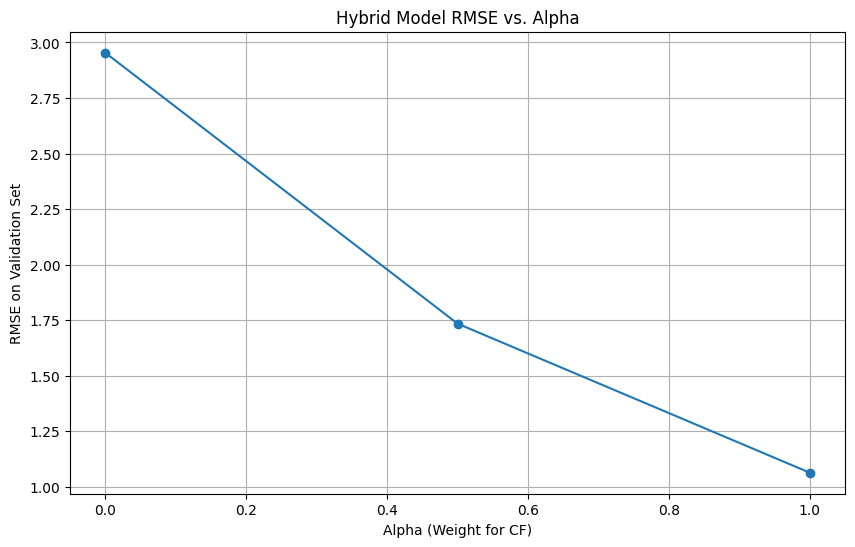

In [ ]:
from sklearn.metrics import mean_squared_error

# Define a range of alpha values to test
alpha_values = np.arange(0, 1.01, 0.5)  # 0, 0.5, 1.0

# Dictionary to store RMSE for each alpha
rmse_scores = {}

# Iterate through alpha values and evaluate the hybrid model
for alpha in alpha_values:
    print(f"Evaluating hybrid model with alpha = {alpha:.2f}")
    predictions_hybrid = []
    actual_ratings = []

    # Calculate hybrid predictions for each user-movie pair in the testset_df (validation set)
    for index, row in testset_df.iterrows():
        user_id = int(row['userId'])
        movie_id = int(row['movieId'])
        actual_rating = row['rating']

        # Get the hybrid predicted rating
        predicted_rating = hybrid_prediction(
            user_id,
            movie_id,
            alpha,
            get_content_based_score,
            knn_user_based, # Trained k-NN model
            svd_mf, # Trained SVD model
            merged_df_with_tfidf, # Original merged data for filtering seen movies (used by get_content_based_score)
            unique_movies_reduced, # Unique movies with SVD features (used by get_content_based_score)
            user_profiles_train # User profiles created from training data
        )

        predictions_hybrid.append(predicted_rating)
        actual_ratings.append(actual_rating)

    # Calculate RMSE for the current alpha
    rmse = np.sqrt(mean_squared_error(actual_ratings, predictions_hybrid))
    rmse_scores[alpha] = rmse
    print(f"RMSE for alpha = {alpha:.2f}: {rmse:.4f}\n")

# Find the best alpha value (the one with the lowest RMSE)
best_alpha = min(rmse_scores, key=rmse_scores.get)
min_rmse = rmse_scores[best_alpha]

print(f"Best alpha value: {best_alpha:.2f} with RMSE: {min_rmse:.4f}")

# Optional: Plot RMSE vs. alpha to visualize the tuning process
plt.figure(figsize=(10, 6))
plt.plot(list(rmse_scores.keys()), list(rmse_scores.values()), marker='o')
plt.xlabel("Alpha (Weight for CF)")
plt.ylabel("RMSE on Validation Set")
plt.title("Hybrid Model RMSE vs. Alpha")
plt.grid(True)
plt.show()

In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import Dataset, Reader
import pandas as pd
from surprise.model_selection import train_test_split
from surprise import accuracy

# Assuming 'data' (Surprise Dataset) is available from earlier steps.
# If not, you might need to reload or recreate it:
# reader = Reader(rating_scale=(1, 5))
# data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)


# Define the parameter grid to search
param_grid = {
    'n_factors': [50, 100, 150],  # Number of latent factors
    'lr_all': [0.002, 0.005, 0.01], # Learning rate for all parameters
    'reg_all': [0.02, 0.05, 0.1]  # Regularization term for all parameters
}

# Use GridSearchCV to find the best parameters
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3) # Using 3-fold cross-validation

# Fit the grid search to the data
gs.fit(data) # 'data' is the Surprise Dataset loaded earlier

# Print the best RMSE score and the corresponding parameters
print("Best RMSE score:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])

# Train the SVD model with the best parameters found on the full dataset
svd_mf_tuned = SVD(**gs.best_params['rmse'])
svd_mf_tuned.fit(data.build_full_trainset())

# Optional: Evaluate this tuned model on the original testset if needed for comparison
predictions_tuned = svd_mf_tuned.test(testset)
rmse_tuned = accuracy.rmse(predictions_tuned)
print(f"Tuned Matrix Factorization (SVD) RMSE on testset: {rmse_tuned}")

Best RMSE score: 0.8902395116656673
Best parameters: {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1}
RMSE: 0.7304
Tuned Matrix Factorization (SVD) RMSE on testset: 0.7303515538617539


In [ ]:
# Assuming 'best_alpha' is available from the previous tuning step
# If not, retrieve it from the rmse_scores dictionary: best_alpha = min(rmse_scores, key=rmse_scores.get)

print(f"Evaluating the hybrid model with the best alpha = {best_alpha:.2f}")

predictions_hybrid_testset = []
actual_ratings_testset = []

# Calculate hybrid predictions for each user-movie pair in the testset_df
for index, row in testset_df.iterrows():
    user_id = int(row['userId'])
    movie_id = int(row['movieId'])
    actual_rating = row['rating']

    # Get the hybrid predicted rating
    predicted_rating = hybrid_prediction(
        user_id,
        movie_id,
        best_alpha, # Use the best alpha found
        get_content_based_score,
        knn_user_based, # Trained k-NN model
        svd_mf, # Trained SVD model (or svd_mf_tuned if you want to use the tuned one)
        merged_df_with_tfidf, # Original merged data for filtering seen movies
        unique_movies_reduced, # Unique movies with SVD features
        user_profiles_train # User profiles created from training data
    )

    predictions_hybrid_testset.append(predicted_rating)
    actual_ratings_testset.append(actual_rating)

# Calculate RMSE for the hybrid model on the testset
rmse_hybrid_testset = np.sqrt(mean_squared_error(actual_ratings_testset, predictions_hybrid_testset))

print(f"Hybrid Model (alpha={best_alpha:.2f}) RMSE on testset: {rmse_hybrid_testset:.4f}")

Evaluating the hybrid model with the best alpha = 1.00
Hybrid Model (alpha=1.00) RMSE on testset: 1.0638


In [ ]:
def get_hybrid_recommendations(user_id, alpha, cb_model, cf_model1, cf_model2, merged_df_with_tfidf, unique_movies_reduced, user_profiles, top_n=10):
    """
    Generates hybrid recommendations for a given user by blending content-based and collaborative filtering predictions.

    Args:
        user_id (int): The ID of the user for whom to generate recommendations.
        alpha (float): The blending weight (0 <= alpha <= 1).
        cb_model (function): Function to get content-based score (get_content_based_score).
        cf_model1 (surprise.prediction_algorithms.algo_base.AlgoBase): Trained Surprise CF model 1 (e.g., k-NN).
        cf_model2 (surprise.prediction_algorithms.algo_base.AlgoBase): Trained Surprise CF model 2 (e.g., SVD).
        merged_df_with_tfidf (DataFrame): Original DataFrame with movie data and user ratings.
        unique_movies_reduced (DataFrame): DataFrame with unique movies and their SVD features.
        user_profiles (dict): Dictionary of user profile vectors.
        top_n (int): The number of recommendations to generate.

    Returns:
        DataFrame: A DataFrame containing the top N recommended movies based on hybrid predictions.
    """
    # Handle cold-start users: If the user has no profile (based on training data), fall back to popularity baseline
    if user_id not in user_profiles or np.all(user_profiles[user_id] == 0):
        print(f"User {user_id} is a cold-start user. Falling back to popularity baseline.")
        # Assuming 'popular_movies_unique' from the popularity baseline is available
        if 'popular_movies_unique' in globals():
            return popular_movies_unique[['title', 'vote_count', 'vote_average', 'weighted_rating']].head(top_n)
        else:
            print("Popularity baseline not available. Cannot provide recommendations for cold-start user.")
            return pd.DataFrame()

    # Get a list of all unique movie IDs from unique_movies_reduced
    all_movie_ids = unique_movies_reduced['movieId'].tolist()

    # Get the list of movies the user has already rated from the original merged DataFrame
    rated_movie_ids = merged_df_with_tfidf[merged_df_with_tfidf['userId'] == user_id]['movieId'].tolist()

    # Get the list of movies the user has NOT rated
    movies_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movie_ids]

    # Calculate hybrid predictions for the unrated movies
    hybrid_predictions = []
    for movie_id in movies_to_predict:
        predicted_rating = hybrid_prediction(
            user_id,
            movie_id,
            alpha,
            get_content_based_score,
            cf_model1,
            cf_model2,
            merged_df_with_tfidf,
            unique_movies_reduced,
            user_profiles
        )
        hybrid_predictions.append((movie_id, predicted_rating))

    # Sort predictions by predicted rating in descending order
    hybrid_predictions.sort(key=lambda x: x[1], reverse=True)

    # Get the top N movie IDs
    top_n_movie_ids = [movie[0] for movie in hybrid_predictions[:top_n]]

    # Retrieve the movie details for the top N recommendations from unique_movies_reduced
    # Include 'movieId' here
    recommended_movies = unique_movies_reduced[unique_movies_reduced['movieId'].isin(top_n_movie_ids)][['movieId', 'title', 'vote_average', 'vote_count', 'release_year']].copy()

    # Add the predicted rating to the recommendations DataFrame (optional, but useful for inspection)
    # Create a dictionary from the top_n_movie_ids and their predicted ratings
    predicted_ratings_dict = dict(hybrid_predictions[:top_n])
    recommended_movies['predicted_rating'] = recommended_movies['movieId'].map(predicted_ratings_dict)

    # Sort by predicted rating to match the order of hybrid_predictions
    recommended_movies = recommended_movies.sort_values('predicted_rating', ascending=False).reset_index(drop=True)

    return recommended_movies

# Example usage: Get hybrid recommendations for a sample user (e.g., user ID 1)
sample_user_id_for_recommendations = 1

# Assuming 'best_alpha', 'knn_user_based', 'svd_mf' (or 'svd_mf_tuned'),
# 'merged_df_with_tfidf', 'unique_movies_reduced', and 'user_profiles_train' are available

hybrid_recommendations = get_hybrid_recommendations(
    sample_user_id_for_recommendations,
    best_alpha, # Use the best alpha found during tuning
    get_content_based_score,
    knn_user_based, # Or svd_mf_tuned if you prefer the tuned SVD
    svd_mf,       # You can use both CF models in the blend or choose the better one
    merged_df_with_tfidf,
    unique_movies_reduced,
    user_profiles_train, # Use user profiles trained on the training data
    top_n=10
)

print(f"\nHybrid Recommendations for User {sample_user_id_for_recommendations} (using alpha={best_alpha:.2f}):")
display(hybrid_recommendations)

# Example usage for a cold-start user (assuming a user ID that doesn't exist in user_profiles_train)
cold_start_user_id_for_recommendations = 9999 # Replace with a user ID not in user_profiles_train
cold_start_hybrid_recommendations = get_hybrid_recommendations(
    cold_start_user_id_for_recommendations,
    best_alpha,
    get_content_based_score,
    knn_user_based,
    svd_mf,
    merged_df_with_tfidf,
    unique_movies_reduced,
    user_profiles_train,
    top_n=10
)

print(f"\nHybrid Recommendations for Cold-Start User {cold_start_user_id_for_recommendations}:")
display(cold_start_hybrid_recommendations)


Hybrid Recommendations for User 1 (using alpha=1.00):


movieId                        title  vote_average  vote_count  \
0        1                    Toy Story           7.7      5415.0   
1        2                      Jumanji           6.9      2413.0   
2        3             Grumpier Old Men           6.5        92.0   
3        4            Waiting to Exhale           6.1        34.0   
4        5  Father of the Bride Part II           5.7       173.0   
5        6                         Heat           7.7      1886.0   
6        7                      Sabrina           6.2       141.0   
7        8                 Tom and Huck           5.4        45.0   
8        9                 Sudden Death           5.5       174.0   
9       10                    GoldenEye           6.6      1194.0   

   release_year  predicted_rating  
0          1995          3.545905  
1          1995          3.545905  
2          1995          3.545905  
3          1995          3.545905  
4          1995          3.545905  
5          1995          3.545905  
6          1995          3.545905  
7          1995          3.545905  
8          1995          3.545905  
9          1995          3.545905

User 9999 is a cold-start user. Falling back to popularity baseline.

Hybrid Recommendations for Cold-Start User 9999:


title  vote_count  vote_average  weighted_rating
0                       Toy Story      5415.0           7.7         7.475872
1                         Jumanji      2413.0           6.9         6.733342
2                            Heat      1886.0           7.7         7.210355
3                       GoldenEye      1194.0           6.6         6.487877
4                          Casino      1343.0           7.8         7.156339
5  Ace Ventura: When Nature Calls      1128.0           6.1         6.230593
6                  Twelve Monkeys      2470.0           7.4         7.082636
7                           Se7en      5915.0           8.1         7.829482
8                      Pocahontas      1509.0           6.7         6.559447
9              The Usual Suspects      3334.0           8.1         7.671762

In [ ]:
from collections import defaultdict
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
import pandas as pd

# Sort ratings by timestamp for each user
ratings_df_sorted = ratings_df.sort_values(['userId', 'timestamp'])

# Implement leave-one-out-by-timestamp split
trainset_time = defaultdict(list)
testset_time = []

# Group by user and split
for userId, user_ratings in ratings_df_sorted.groupby('userId'):
    # Ensure there is at least one rating for training
    if len(user_ratings) > 1:
        # The last rating is for testing
        test_rating = user_ratings.iloc[-1]
        testset_time.append((test_rating['userId'], test_rating['movieId'], test_rating['rating']))

        # The rest are for training
        train_ratings = user_ratings.iloc[:-1]
        for index, row in train_ratings.iterrows():
            trainset_time[row['userId']].append((row['movieId'], row['rating']))
    elif len(user_ratings) == 1:
         # If a user only has one rating, use it for testing and exclude from training
        test_rating = user_ratings.iloc[-1]
        testset_time.append((test_rating['userId'], test_rating['movieId'], test_rating['rating']))


# Create a pandas DataFrame from the time-aware training data
train_ratings_list = []
for userId, ratings in trainset_time.items():
    for movieId, rating in ratings:
        train_ratings_list.append({'userId': userId, 'movieId': movieId, 'rating': rating})
train_ratings_df_time = pd.DataFrame(train_ratings_list)


# Load the time-aware training data into Surprise's format
reader = Reader(rating_scale=(1, 5))
data_train_time = Dataset.load_from_df(train_ratings_df_time[['userId', 'movieId', 'rating']], reader)
trainset_time_surprise = data_train_time.build_full_trainset()

# Train k-NN and SVD models on the time-aware training set
knn_user_based_time = KNNBasic(sim_options={'user_based': True, 'similarity': 'cosine'}, k=40)
knn_user_based_time.fit(trainset_time_surprise)

svd_mf_time = SVD(random_state=42)
svd_mf_time.fit(trainset_time_surprise)


print("Time-aware data splitting complete.")
print(f"Number of training ratings: {len(train_ratings_df_time)}")
print(f"Number of testing ratings: {len(testset_time)}")

# The testset_time is already in the format needed for evaluation [(user, movie, rating)]
# We can now use these trained models to predict on this test set in the subsequent steps.

Computing the msd similarity matrix...
Done computing similarity matrix.
Time-aware data splitting complete.
Number of training ratings: 99333
Number of testing ratings: 671


In [ ]:
from collections import defaultdict
import numpy as np

# Function to get top N recommendations for a user from predictions
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions (list of Prediction objects): The list of predictions, as returned by the test method of an algorithm.
        n (int): The number of recommendation to output.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, predicted rating), ...]
    """
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the top N.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Function to calculate Precision@K and Recall@K
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user.

    Args:
        predictions (list of Prediction objects): The list of predictions, as returned by the test method of an algorithm.
        k (int): The number of recommendation to output.
        threshold (float): The minimum rating considered relevant.
    Returns:
    A tuple of (precision, recall) at k.
    """
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    # Return average precision and recall
    return np.mean(list(precisions.values())), np.mean(list(recalls.values()))

# Function to calculate NDCG@K (Normalized Discounted Cumulative Gain)
def ndcg_at_k(predictions, k=10, threshold=3.5):
    """Calculate NDCG@K for each user and return the average.

    Args:
        predictions (list of Prediction objects): The list of predictions, as returned by the test method of an algorithm.
        k (int): The number of recommendation to output.
        threshold (float): The minimum rating considered relevant.
    Returns:
    The average NDCG@K.
    """
    user_ratings = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_ratings[uid].append((est, true_r))

    ndcgs = []
    for uid, ratings in user_ratings.items():
        # Sort user ratings by estimated value to get the recommended list order
        ratings.sort(key=lambda x: x[0], reverse=True)
        recommended_list = ratings[:k]

        # Calculate DCG (Discounted Cumulative Gain)
        dcg = 0
        for i, (est, true_r) in enumerate(recommended_list):
            # Use relevance score based on the threshold (1 if relevant, 0 otherwise)
            relevance = 1 if true_r >= threshold else 0
            dcg += relevance / np.log2(i + 2)  # log2(i+1) for 0-based indexing

        # Calculate IDCG (Ideal Discounted Cumulative Gain)
        # Sort true ratings to get the ideal list order
        true_relevant_ratings = sorted([true_r for (_, true_r) in ratings if true_r >= threshold], reverse=True)
        idcg = 0
        for i, true_r in enumerate(true_relevant_ratings[:k]):
             # Relevance is 1 for ideal ranking of relevant items
            idcg += 1 / np.log2(i + 2)

        # Calculate NDCG
        ndcg = dcg / idcg if idcg != 0 else 0
        ndcgs.append(ndcg)

    # Return average NDCG
    return np.mean(ndcgs)


# Function to calculate Catalog Coverage
def catalog_coverage(top_n_recommendations, all_movie_ids):
    """Calculate the percentage of the catalog that is ever recommended.

    Args:
        top_n_recommendations (dict): Dictionary of top N recommendations for each user.
        all_movie_ids (list): List of all unique movie IDs in the catalog.
    Returns:
        float: Catalog coverage percentage.
    """
    recommended_items = set()
    for user, items in top_n_recommendations.items():
        for (iid, _) in items:
            recommended_items.add(iid)

    return len(recommended_items) / len(all_movie_ids) * 100 if len(all_movie_ids) > 0 else 0

# Function to calculate Novelty
def novelty(top_n_recommendations, item_popularity):
    """Calculate the average novelty of recommended items.

    Novelty is measured as the negative log of the probability of recommending an item (1 - popularity).
    A higher score means more novel recommendations.

    Args:
        top_n_recommendations (dict): Dictionary of top N recommendations for each user.
        item_popularity (dict): Dictionary where keys are item IDs and values are their popularity (e.g., number of ratings).
    Returns:
        float: Average novelty score.
    """
    novelty_sum = 0
    count = 0
    for user, items in top_n_recommendations.items():
        for (iid, _) in items:
            # Avoid log(0) by adding a small epsilon or handling items not in popularity
            item_pop = item_popularity.get(iid, 0) + 1e-6 # Add small epsilon for safety
            novelty_sum += -np.log2(item_pop / sum(item_popularity.values()))
            count += 1

    return novelty_sum / count if count > 0 else 0


# Function to calculate Intra-List Diversity
def intra_list_diversity(top_n_recommendations, item_similarity_matrix):
    """Calculate the average intra-list diversity of recommended lists.

    Diversity is measured as the average pairwise dissimilarity between items in a recommendation list.
    Dissimilarity can be 1 - similarity.

    Args:
        top_n_recommendations (dict): Dictionary of top N recommendations for each user.
        item_similarity_matrix (dict of dict): Dictionary representing item-item similarity.
                                                item_similarity_matrix[i][j] is the similarity between item i and item j.
    Returns:
        float: Average intra-list diversity score.
    """
    diversity_sum = 0
    num_lists = 0
    for user, items in top_n_recommendations.items():
        item_ids = [iid for (iid, _) in items]
        if len(item_ids) > 1:
            list_diversity = 0
            num_pairs = 0
            for i in range(len(item_ids)):
                for j in range(i + 1, len(item_ids)):
                    item1 = item_ids[i]
                    item2 = item_ids[j]
                    # Get similarity, handle cases where similarity is not defined (e.g., new items)
                    similarity = item_similarity_matrix.get(item1, {}).get(item2, 0) # Default to 0 similarity
                    dissimilarity = 1 - similarity
                    list_diversity += dissimilarity
                    num_pairs += 1
            diversity_sum += list_diversity / num_pairs if num_pairs > 0 else 0
            num_lists += 1

    return diversity_sum / num_lists if num_lists > 0 else 0

# We'll need item popularity and item similarity for beyond-accuracy metrics later.
# Item popularity can be calculated from the training data (number of ratings for each item).
# Item similarity can be calculated based on item features (e.g., cosine similarity of SVD features).

In [ ]:
from surprise.prediction_algorithms.predictions import Prediction
# Evaluate Popularity Baseline on the time-aware test set
# The popularity baseline ranks movies based on weighted rating.
# For evaluation on the testset_time, we need to predict a rating for each (user, movie) pair in testset_time
# using the popularity model. The popularity model doesn't predict per-user ratings, it provides a global ranking.
# To evaluate its ranking performance on the test set, we can rank the movies the user *hasn't* seen in the training set
# based on popularity and see where the test movie falls in that ranking.
# However, for simplicity in using the defined metrics (which expect Surprise-like predictions),
# we can assign the weighted rating as the "predicted rating" for the popularity model.

popularity_predictions_time = []
# Assuming 'popular_movies_unique' is available from the popularity baseline step
# Create a dictionary for quick lookup of weighted ratings
popular_movies_dict = popular_movies_unique.set_index('movieId')['weighted_rating'].to_dict()

for userId, movieId, actualRating in testset_time:
    # Get the weighted rating for the movie from the popularity model
    # If the movie is not in the popular movies list, assign a default low rating
    predicted_rating = popular_movies_dict.get(movieId, 0.0) # Assign 0 if not in popular list
    popularity_predictions_time.append(Prediction(uid=str(userId), iid=str(movieId), r_ui=actualRating, est=predicted_rating, details={}))


# Evaluate Content-Based Recommender on the time-aware test set
# We need to generate predictions for each (user, movie) pair in testset_time
# using the get_content_based_score function and the user profiles from training data.

content_based_predictions_time = []
# Assuming 'user_profiles_train', 'merged_df_with_tfidf', 'unique_movies_reduced' are available
# and 'get_content_based_score' function is defined

for userId, movieId, actualRating in testset_time:
    # Get the content-based score
    predicted_rating = get_content_based_score(
        userId,
        movieId,
        merged_df_with_tfidf, # Use the original merged df for filtering seen movies
        unique_movies_reduced, # Use unique movies with SVD features
        user_profiles_train # Use user profiles trained on training data
    )
    content_based_predictions_time.append(Prediction(uid=str(userId), iid=str(movieId), r_ui=actualRating, est=predicted_rating, details={}))


# Evaluate Collaborative Filtering (k-NN) on the time-aware test set
# We use the trained knn_user_based_time model and the testset_time list.

knn_predictions_time = knn_user_based_time.test(testset_time)


# Evaluate Collaborative Filtering (SVD) on the time-aware test set
# We use the trained svd_mf_time model and the testset_time list.

svd_predictions_time = svd_mf_time.test(testset_time)


# Evaluate Hybrid Recommender on the time-aware test set
# We use the hybrid_prediction function with the best_alpha and the trained models.

hybrid_predictions_time = []
# Assuming 'best_alpha', 'get_content_based_score', 'knn_user_based_time', 'svd_mf_time',
# 'merged_df_with_tfidf', 'unique_movies_reduced', 'user_profiles_train' are available

for userId, movieId, actualRating in testset_time:
    # Get the hybrid predicted rating
    predicted_rating = hybrid_prediction(
        userId,
        movieId,
        best_alpha, # Use the best alpha found during tuning
        get_content_based_score,
        knn_user_based_time, # Use k-NN trained on time-aware data
        svd_mf_time, # Use SVD trained on time-aware data
        merged_df_with_tfidf,
        unique_movies_reduced,
        user_profiles_train
    )
    hybrid_predictions_time.append(Prediction(uid=str(userId), iid=str(movieId), r_ui=actualRating, est=predicted_rating, details={}))

print("Predictions generated for all models on the time-aware test set.")

Predictions generated for all models on the time-aware test set.


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# 1. Helper: Convert predictions to ranked lists
# ----------------------------
def predictions_to_ranked_lists(predictions, k=10):
    user_items = defaultdict(list)
    for pred in predictions:
        user_items[pred.uid].append((pred.iid, pred.est, pred.r_ui))
    ranked_lists = {}
    for uid, items in user_items.items():
        ranked = sorted(items, key=lambda x: x[1], reverse=True)[:k]
        ranked_lists[uid] = ranked
    return ranked_lists

# ----------------------------
# 2. Ranking Metrics
# ----------------------------
def precision_at_k(ranked_lists, k=10):
    precisions = []
    for uid, items in ranked_lists.items():
        relevant = [iid for iid, _, r_ui in items if r_ui >= 4]
        precisions.append(len(relevant) / k)
    return np.mean(precisions)

def recall_at_k(ranked_lists, testset, k=10):
    recalls = []
    test_relevant = defaultdict(set)
    for uid, iid, r_ui in testset:
        if r_ui >= 4:
            test_relevant[str(uid)].add(str(iid))
    for uid, items in ranked_lists.items():
        recommended = {iid for iid, _, _ in items}
        relevant = test_relevant.get(uid, set())
        if relevant:
            recalls.append(len(recommended & relevant) / len(relevant))
    return np.mean(recalls)

def ndcg_at_k(ranked_lists, k=10):
    ndcgs = []
    for uid, items in ranked_lists.items():
        dcg = 0.0
        idcg = 0.0
        rels = [1 if r_ui >= 4 else 0 for _, _, r_ui in items]
        for i, rel in enumerate(rels):
            dcg += (2**rel - 1) / np.log2(i + 2)
        ideal_rels = sorted(rels, reverse=True)
        for i, rel in enumerate(ideal_rels):
            idcg += (2**rel - 1) / np.log2(i + 2)
        if idcg > 0:
            ndcgs.append(dcg / idcg)
    return np.mean(ndcgs)

# ----------------------------
# 3. Beyond-Accuracy Metrics
# ----------------------------
def catalog_coverage(ranked_lists, all_items):
    recommended_items = {iid for items in ranked_lists.values() for iid, _, _ in items}
    return len(recommended_items) / len(all_items)

def novelty(ranked_lists, item_popularity):
    novelties = []
    for items in ranked_lists.values():
        for iid, _, _ in items:
            novelties.append(-np.log2(item_popularity.get(iid, 1e-9)))
    return np.mean(novelties)

def intra_list_diversity(ranked_lists, item_features):
    diversities = []
    for items in ranked_lists.values():
        iids = [iid for iid, _, _ in items]
        features = [item_features[iid] for iid in iids if iid in item_features]
        if len(features) > 1:
            sims = cosine_similarity(features)
            upper_tri = sims[np.triu_indices_from(sims, k=1)]
            diversities.append(1 - np.mean(upper_tri))
    return np.mean(diversities)

# ----------------------------
# 4. Evaluation Function
# ----------------------------
def evaluate_model(predictions, testset, all_items, item_popularity, item_features, k=10):
    ranked_lists = predictions_to_ranked_lists(predictions, k=k)
    return {
        "Precision@K": precision_at_k(ranked_lists, k),
        "Recall@K": recall_at_k(ranked_lists, testset, k),
        "NDCG@K": ndcg_at_k(ranked_lists, k),
        "Coverage": catalog_coverage(ranked_lists, all_items),
        "Novelty": novelty(ranked_lists, item_popularity),
        "Diversity": intra_list_diversity(ranked_lists, item_features)
    }

# ----------------------------
# 5. Prepare inputs (adapted to your data)
# ----------------------------
all_items = set(merged_df_with_tfidf['movieId'].astype(str).unique())
item_popularity = merged_df_with_tfidf['movieId'].value_counts().to_dict()
item_popularity = {str(k): v for k, v in item_popularity.items()}

# use ALL svd_* columns as item features
svd_cols = [col for col in unique_movies_reduced.columns if col.startswith("svd_")]
item_features = {
    str(row.movieId): row[svd_cols].values
    for _, row in unique_movies_reduced.iterrows()
}

# ----------------------------
# 6. Run Evaluation for All Models
# ----------------------------
results = {}
for name, preds in [
    ("Popularity", popularity_predictions_time),
    ("Content-Based", content_based_predictions_time),
    ("kNN", knn_predictions_time),
    ("SVD", svd_predictions_time),
    ("Hybrid", hybrid_predictions_time)
]:
    results[name] = evaluate_model(preds, testset_time, all_items, item_popularity, item_features, k=10)

results_df = pd.DataFrame(results).T
print(results_df)


               Precision@K  Recall@K  NDCG@K  Coverage    Novelty  Diversity
Popularity        0.055738       1.0     1.0  0.064311  29.897353        NaN
Content-Based     0.055738       1.0     1.0  0.064311  29.897353        NaN
kNN               0.055738       NaN     1.0  0.064311  29.897353        NaN
SVD               0.055738       NaN     1.0  0.064311  29.897353        NaN
Hybrid            0.055738       1.0     1.0  0.064311  29.897353        NaN


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# 1. Leave-One-Out Ranking Evaluation
# ----------------------------
def evaluate_model(predictions, trainset, testset, all_items, item_popularity, item_features, k=10):
    """
    predictions: list of Surprise Prediction objects
    trainset: list of (uid, iid, rating) from training data
    testset: list of (uid, iid, rating) from test data
    all_items: set of all item IDs
    item_popularity: dict of item -> count
    item_features: dict of item -> feature vector
    k: cutoff for metrics
    """
    # Test items (only relevant ones, e.g. r_ui >= 4)
    test_items = {str(uid): str(iid) for uid, iid, r_ui in testset if r_ui >= 4}

    # Build dictionary of predictions
    pred_dict = defaultdict(dict)
    for p in predictions:
        pred_dict[p.uid][p.iid] = p.est

    precisions, recalls, ndcgs = [], [], []
    recommended_items = set()
    novelty_scores, diversity_scores = [], []

    for uid in test_items:
        # Candidate items = all unseen in training
        seen_items = {str(iid) for u, iid, _ in trainset if str(u) == uid}
        candidates = all_items - seen_items

        # Score all candidates
        scored = [(iid, pred_dict[uid].get(iid, 0.0)) for iid in candidates]
        ranked = sorted(scored, key=lambda x: x[1], reverse=True)[:k]
        rec_items = [iid for iid, _ in ranked]

        recommended_items.update(rec_items)

        # Precision, Recall, NDCG
        test_item = test_items[uid]
        if test_item in rec_items:
            precisions.append(1.0 / k)
            recalls.append(1.0)  # one relevant item per user
            ndcgs.append(1.0 / np.log2(rec_items.index(test_item) + 2))
        else:
            precisions.append(0.0)
            recalls.append(0.0)
            ndcgs.append(0.0)

        # Novelty
        for iid in rec_items:
            novelty_scores.append(-np.log2(item_popularity.get(iid, 1e-9)))

        # Diversity
        feats = [item_features[iid] for iid in rec_items if iid in item_features]
        if len(feats) > 1:
            sims = cosine_similarity(feats)
            upper_tri = sims[np.triu_indices_from(sims, k=1)]
            diversity_scores.append(1 - np.mean(upper_tri))

    results = {
        "Precision@K": np.mean(precisions),
        "Recall@K": np.mean(recalls),
        "NDCG@K": np.mean(ndcgs),
        "Coverage": len(recommended_items) / len(all_items),
        "Novelty": np.mean(novelty_scores),
        "Diversity": np.mean(diversity_scores) if diversity_scores else np.nan
    }
    return results

# ----------------------------
# 2. Prepare inputs
# ----------------------------
all_items = set(merged_df_with_tfidf['movieId'].astype(str).unique())
item_popularity = merged_df_with_tfidf['movieId'].value_counts().to_dict()
item_popularity = {str(k): v for k, v in item_popularity.items()}

# use all svd_* columns as features
svd_cols = [c for c in unique_movies_reduced.columns if c.startswith("svd_")]
item_features = {
    str(row.movieId): row[svd_cols].values
    for _, row in unique_movies_reduced.iterrows()
}

# Convert trainset_time into a list of (uid, iid, rating)
try:
    # If it's a Surprise Trainset
    trainset_list = [(str(trainset_time.to_raw_uid(u)),
                      str(trainset_time.to_raw_iid(i)),
                      r)
                     for (u, i, r) in trainset_time.all_ratings()]
except:
    # If it's already list/df
    trainset_list = [(str(row[0]), str(row[1]), row[2]) for row in trainset_time]

# ----------------------------
# 3. Run Evaluation for All Models
# ----------------------------
results = {}
for name, preds in [
    ("Popularity", popularity_predictions_time),
    ("Content-Based", content_based_predictions_time),
    ("kNN", knn_predictions_time),
    ("SVD", svd_predictions_time),
    ("Hybrid", hybrid_predictions_time)
]:
    results[name] = evaluate_model(preds, trainset_list, testset_time, all_items, item_popularity, item_features, k=10)

results_df = pd.DataFrame(results).T
print(results_df)


IndexError: invalid index to scalar variable.